<a href="https://colab.research.google.com/github/douglasmmachado/ExploratoryDataAnalysis/blob/master/Timeseries_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring the timeseries approach for the unified database

---



---



# Loading libs and database

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

raw_data_url ="https://raw.githubusercontent.com/douglasmmachado/ExploratoryDataAnalysis/master/project_database.csv"
df=pd.read_csv(raw_data_url, index_col=0)

categorical_features = ['ID_REF', 'ID_SITE_RATTACHE', 'CODE_ATC', 'HOSPI_CODE_UCD']
date_features = ['DATE_MOUV', 'WEEK', 'MONTH', 'YEAR']
numerical_features = ['N_UFS', 'QUANTITY', 'N_ETB', 'POPULATION', 'P_MEDICAL', 'PN_MEDICAL', 'LIT_HC', 'LIT_HP', 'SEJ_MCO', 'SEJ_HAD', 'SEJ_PSY', 'SEJ_SSR']

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75692 entries, 0 to 75691
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID_REF            75689 non-null  object 
 1   ID_SITE_RATTACHE  75690 non-null  object 
 2   CODE_ATC          75685 non-null  object 
 3   HOSPI_CODE_UCD    75690 non-null  object 
 4   DATE_MOUV         75685 non-null  object 
 5   N_UFS             75692 non-null  int64  
 6   QUANTITY          75685 non-null  float64
 7   WEEK              75685 non-null  float64
 8   MONTH             75692 non-null  int64  
 9   YEAR              75685 non-null  float64
 10  N_ETB             75692 non-null  int64  
 11  POPULATION        75692 non-null  float64
 12  P_MEDICAL         75692 non-null  int64  
 13  PN_MEDICAL        75692 non-null  int64  
 14  LIT_HC            75685 non-null  float64
 15  LIT_HP            75692 non-null  float64
 16  SEJ_MCO           75692 non-null  int64 

<ipython-input-15-af9092c990bd>:8: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(raw_data_url, index_col=0)


# Data cleaning

In [16]:
df = df.drop_duplicates()
df = df.dropna()
df['DATE_MOUV'] = pd.to_datetime(df['DATE_MOUV'], 
               format='%Y-%m-%d')  # Changed the type of date too
               
for column in categorical_features:
  df[column] = df[column].astype('string')

df.sample(5)

<ipython-input-16-1c25a3c43dd3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DATE_MOUV'] = pd.to_datetime(df['DATE_MOUV'],
<ipython-input-16-1c25a3c43dd3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].astype('string')


ID_REF ID_SITE_RATTACHE CODE_ATC HOSPI_CODE_UCD  DATE_MOUV  N_UFS  \
4576    800851          HOSPI_1  B05XA03  3400892761527 2017-07-11      4   
14975   830631          HOSPI_1  N05BA12  3400892075761 2017-06-20      8   
41580   503386          HOSPI_3  N02BE01  3400893875490 2016-09-02     15   
48087   504394          HOSPI_3  N05BA04  3400890837149 2014-05-29      1   
25604  9276152          HOSPI_2  B05XA03  3400892761527 2018-09-17     18   

       QUANTITY  WEEK  MONTH    YEAR  ...  POPULATION  P_MEDICAL  PN_MEDICAL  \
4576      920.0  28.0      7  2017.0  ...    572443.0        806        5303   
14975     670.0  25.0      6  2017.0  ...    572443.0        806        5303   
41580     780.0  35.0      9  2016.0  ...   1132481.0       1290        7336   
48087      10.0  22.0      5  2014.0  ...   1107398.0       1158        7129   
25604     875.0  38.0      9  2018.0  ...    541454.0        703        5007   

       LIT_HC  LIT_HP  SEJ_MCO  SEJ_HAD  SEJ_PSY  SEJ_SSR  SEJ_SLD  
4576   1360.0   106.0    80667        0        0     1239      122  
14975  1360.0   106.0    80667        0        0     1239      122  
41580  2030.0   506.0   120193      787     2755     1309       88  
48087  2063.0   521.0   117781      594     2903     1302       97  
25604  1159.0   139.0    74663        0     1193      237        0  

[5 rows x 21 columns]

## Removing outliers by hospital and by drug

In [78]:
def remove_outliers(df, columns, verbose = False):
  N_macro = df.shape[0]
  print('N: ', N_macro)
  for col in columns:
      for id_ref in df['ID_REF'].unique():

          # Filter the dataframe for the specific ID_REF
          df_subset = df[df['ID_REF'] == id_ref]
          N = df_subset.shape[0]

          # Calculate statistics for the column within the ID_REF subset
          z_scores = np.abs(stats.zscore(df_subset[col]))
          threshold = 3

          # Remove outliers based on the z-score threshold within the ID_REF subset
          df_subset = df_subset[z_scores < threshold]
          N_new = df_subset.shape[0]
          delta = N - N_new

          # Update the original dataframe with the filtered values
          df = pd.concat([df[df['ID_REF'] != id_ref], df_subset])

          if verbose:
            if delta > 0:
                print(f'Column: {col}')
                print(f'ID_REF: {id_ref}')
                print(f'Removed outliers: {delta}')
                print(f'Removed percentage: {(100 * delta / N):.3}%')
                print()


  N_macro_new = df.shape[0]
  print('N_new: ', N_macro_new)
  delta = N_macro - N_macro_new
  print(f'Total removed outliers: {(100 * delta / N_macro):.3}%')
  return df

In [89]:
def visualize_distribution(df, features):
  '''
    Plot of distribution for the numerical features after removing the outliers
  '''

  fig, axes = plt.subplots(4, 3,sharex=False, figsize=(20,20))

  i = 0
  j = 0
  for column in features:
    sns.histplot(df[column], kde=True, stat="density", kde_kws=dict(cut=3),alpha=.4, edgecolor=(1, 1, 1, .4),ax=axes[i, j]).set(title='Distribution of: ' + str(column))
    if j == 2:
      i += 1
      j = 0
    else:
      j+=1

In [94]:
# Separating databases

n_medicines = df['ID_REF'].nunique()
print('Number of different medicines: ', n_medicines)

df_h1 = df[df["ID_SITE_RATTACHE"] == "HOSPI_1"]
df_h2 = df[df["ID_SITE_RATTACHE"] == "HOSPI_2"]
df_h3 = df[df["ID_SITE_RATTACHE"] == "HOSPI_3"]
df_h4 = df[df["ID_SITE_RATTACHE"] == "HOSPI_4"]


Number of different medicines:  84


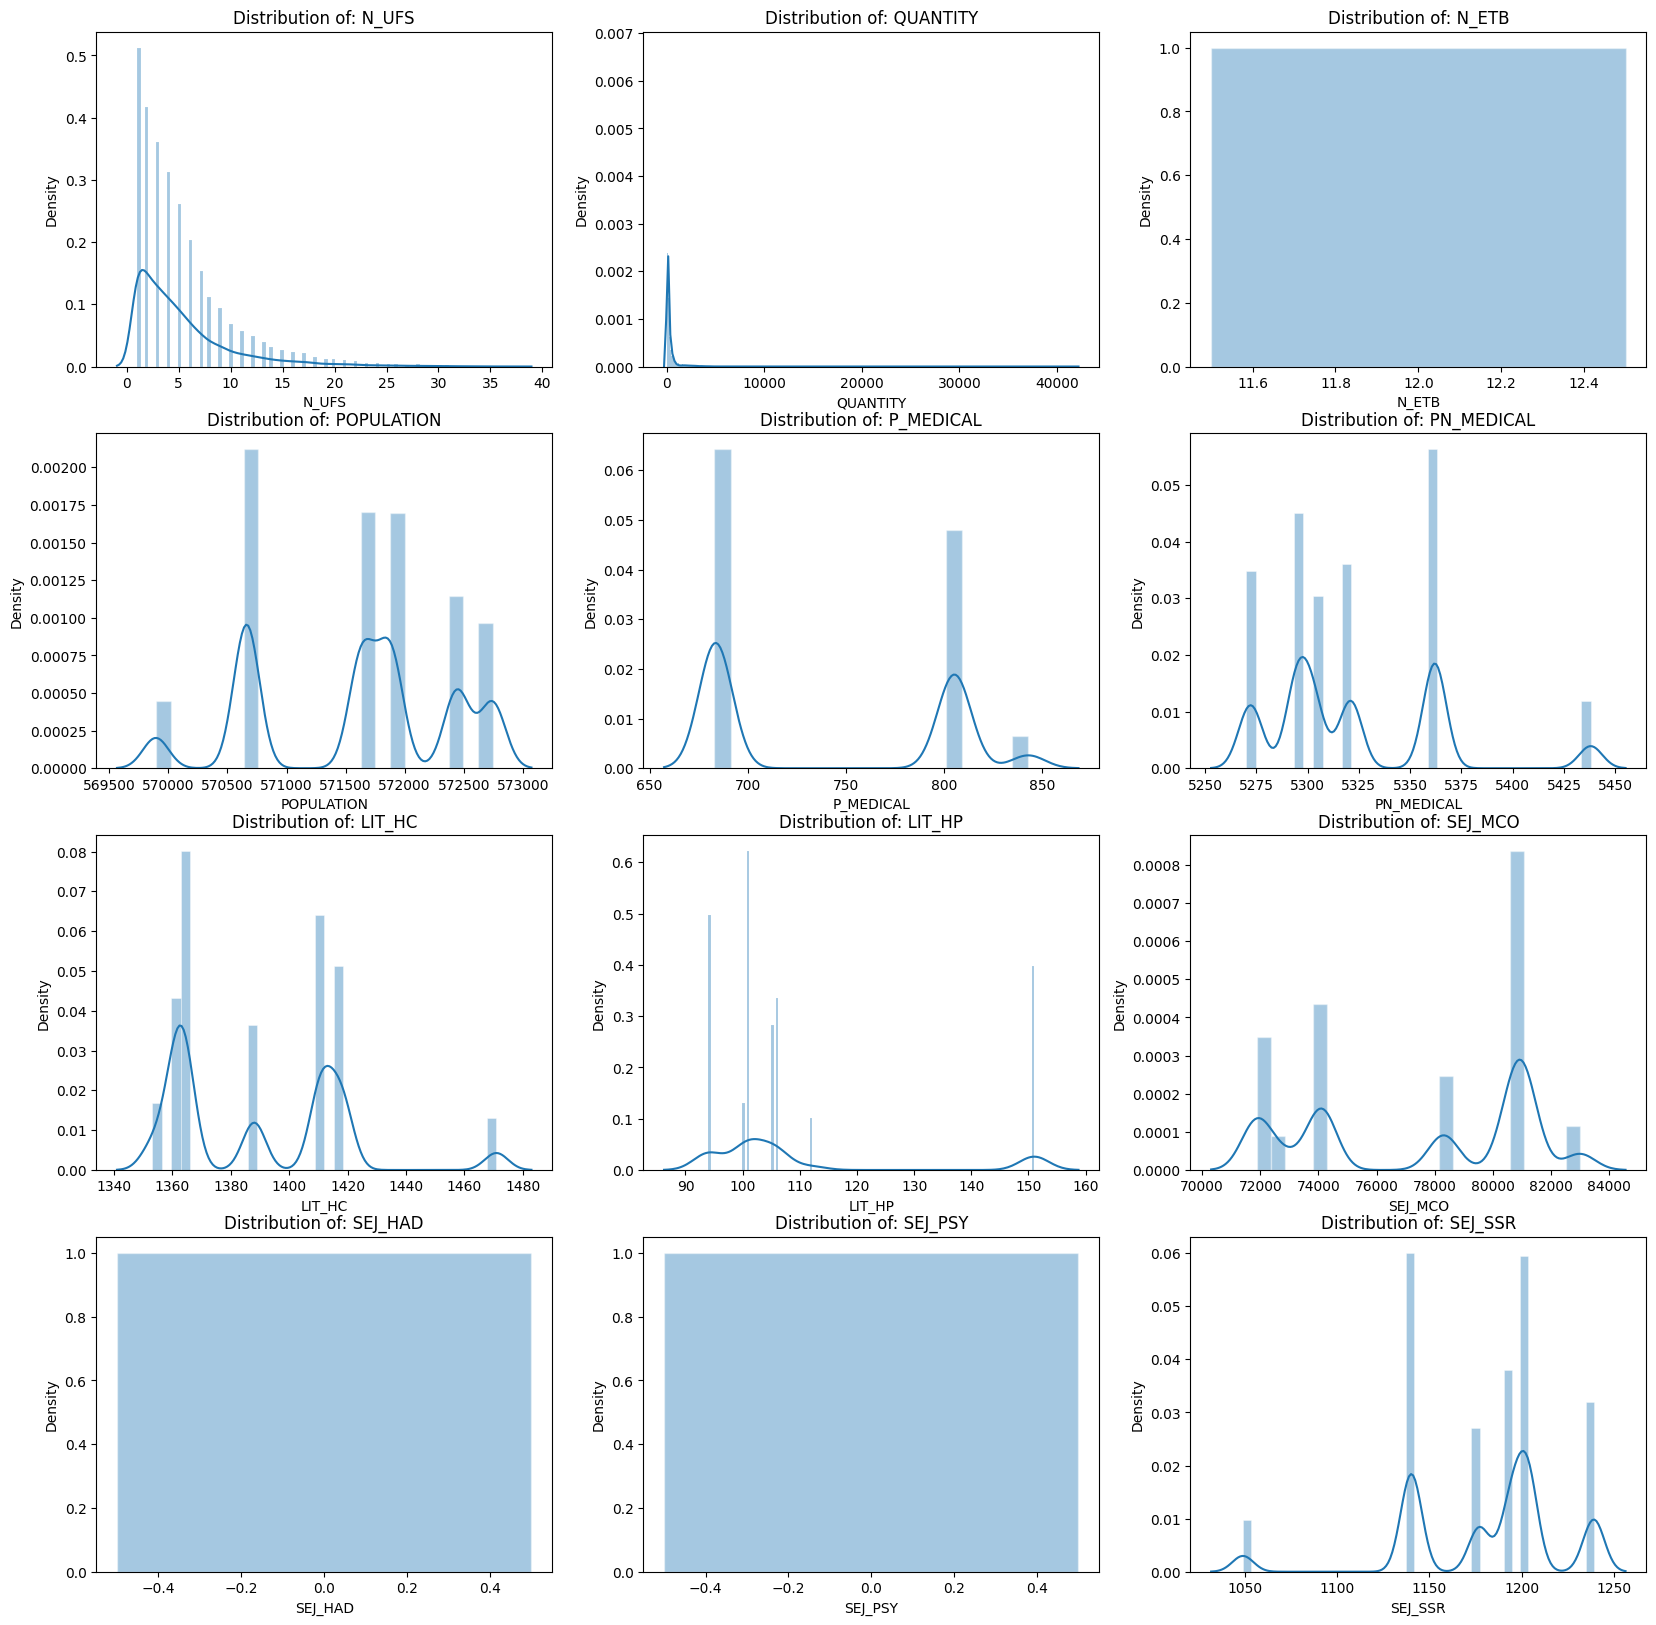

In [95]:
# Visualizing distribution before outlier removing
# Hospital 1
visualize_distribution(df_h1, numerical_features)

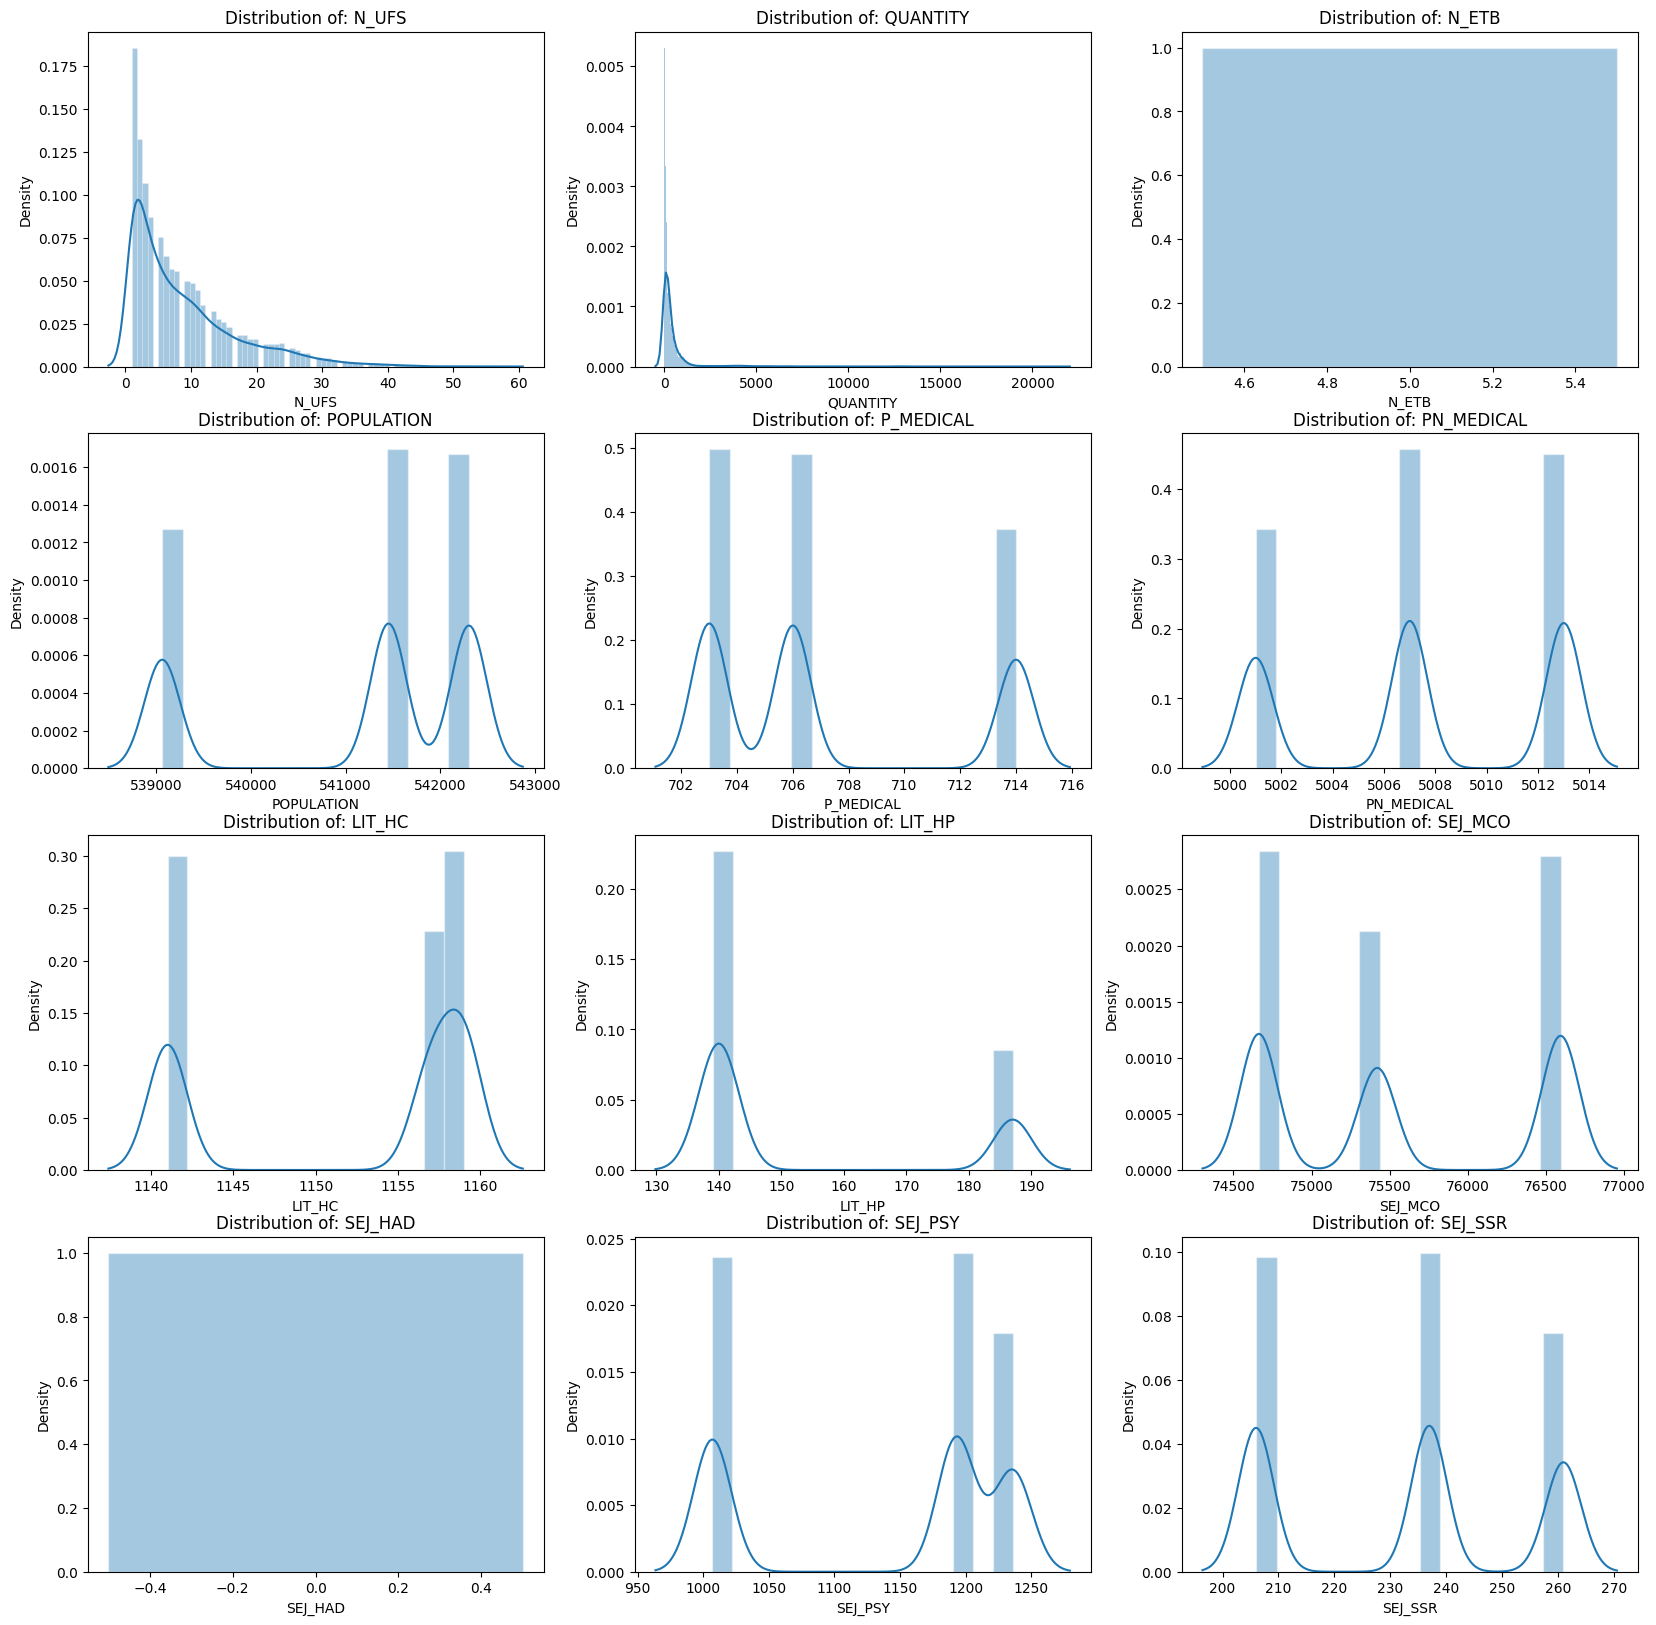

In [96]:
# Visualizing distribution before outlier removing
# Hospital 2
visualize_distribution(df_h2, numerical_features)

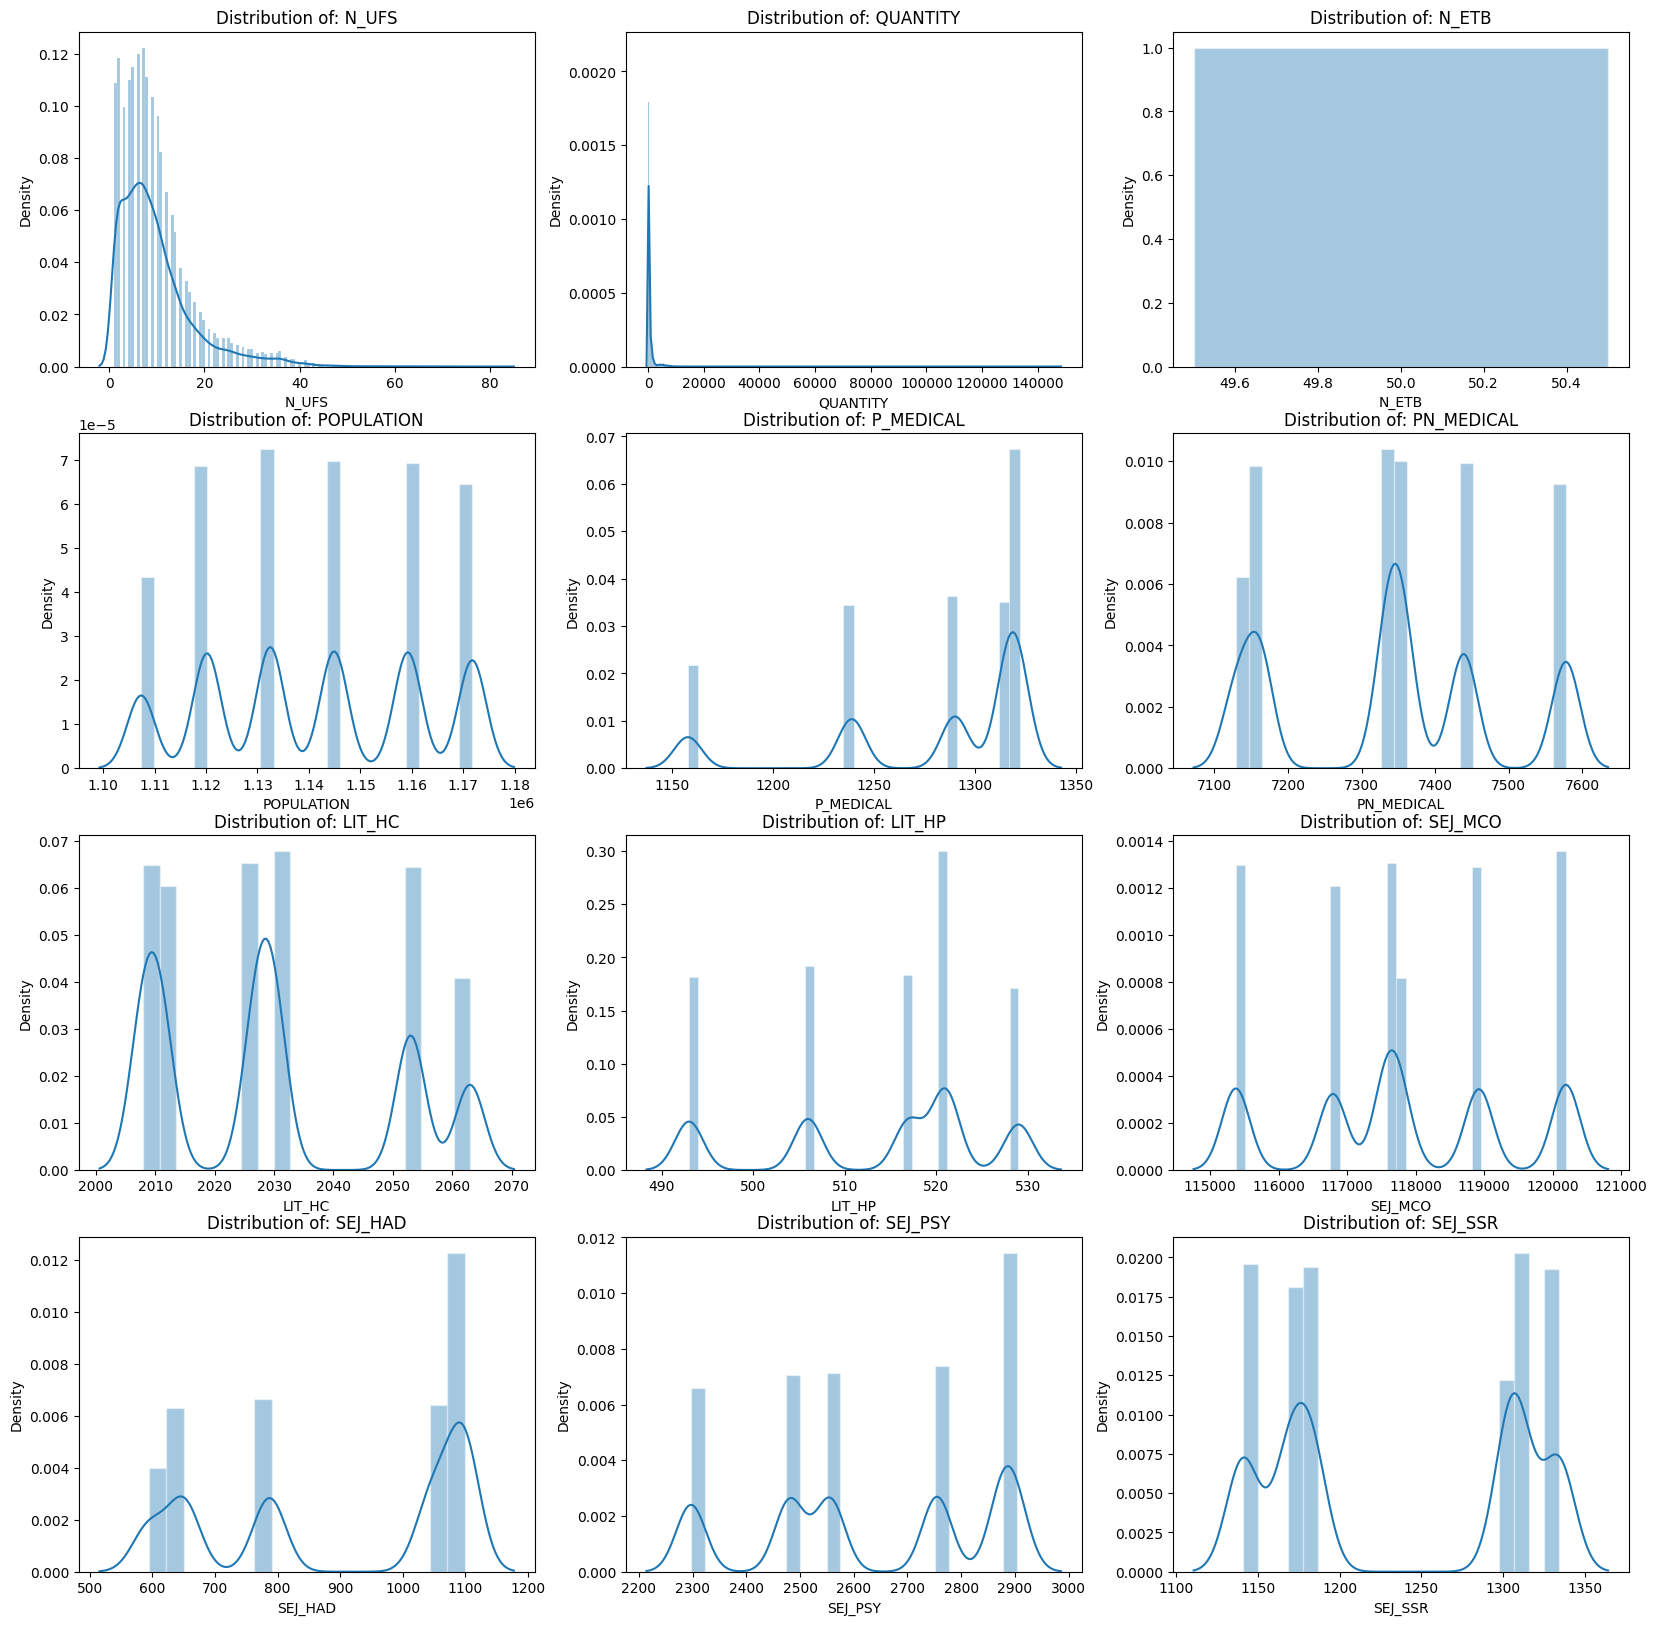

In [97]:
# Visualizing distribution before outlier removing
# Hospital 3
visualize_distribution(df_h3, numerical_features)

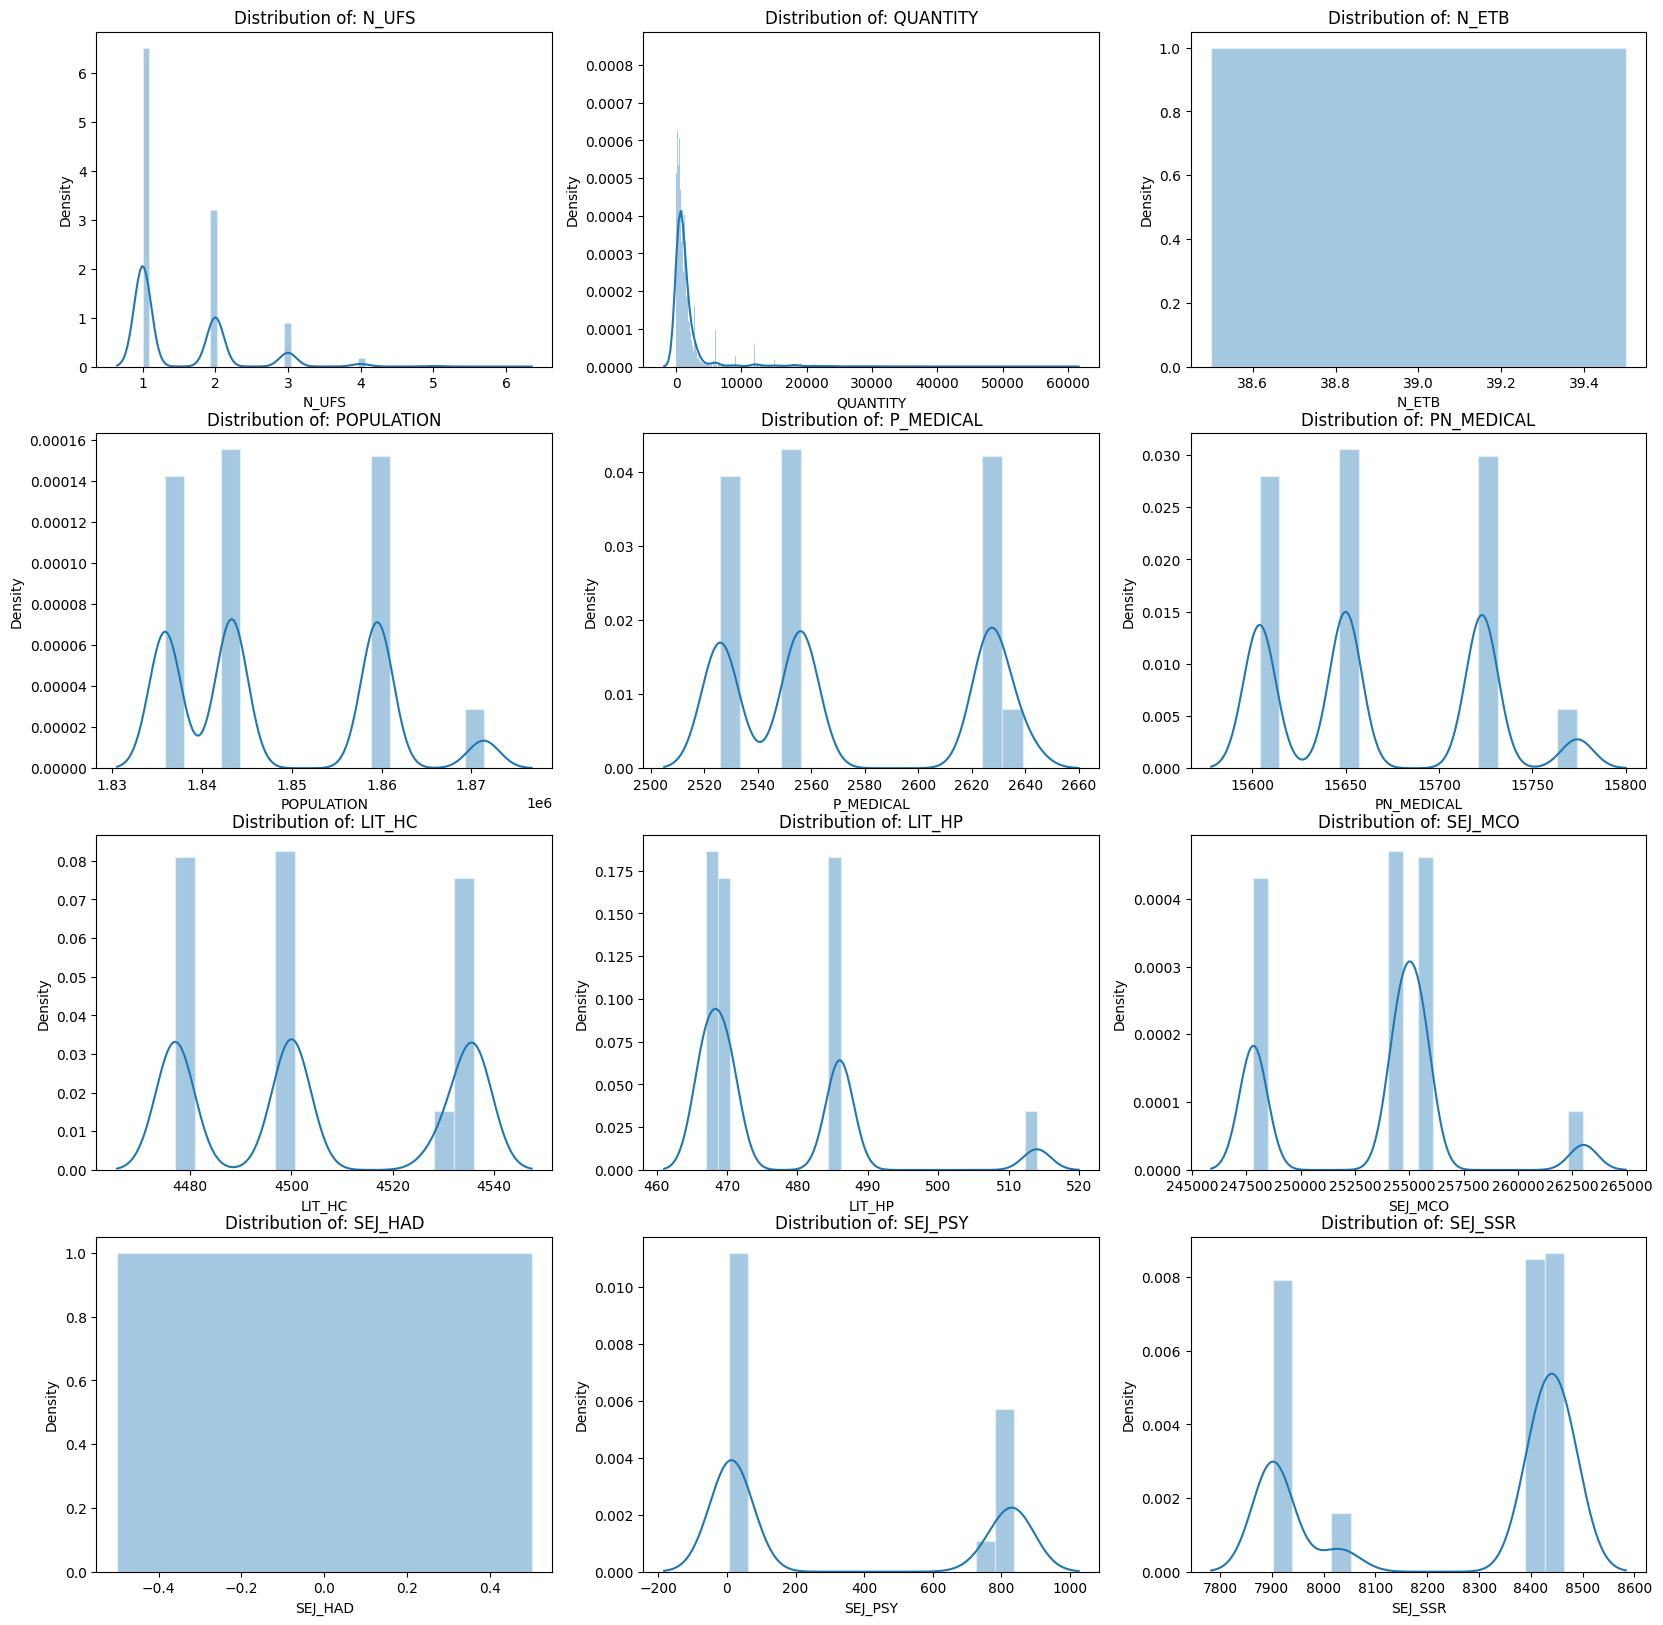

In [98]:
# Visualizing distribution before outlier removing
# Hospital 4
visualize_distribution(df_h4, numerical_features)

In [99]:

print("-"*100)
df_h1 = remove_outliers(df_h1, ["QUANTITY"], verbose = False)

print("-"*100)
df_h2 = remove_outliers(df_h2, ["QUANTITY"], verbose = False)

print("-"*100)
df_h3 = remove_outliers(df_h3, ["QUANTITY"], verbose = False)

print("-"*100)
df_h4 = remove_outliers(df_h4, ["QUANTITY"], verbose = False)


----------------------------------------------------------------------------------------------------
N:  22725
N_new:  22357
Total removed outliers: 1.62%
----------------------------------------------------------------------------------------------------
N:  15439
N_new:  15231
Total removed outliers: 1.35%
----------------------------------------------------------------------------------------------------
N:  27591
N_new:  27386
Total removed outliers: 0.743%
----------------------------------------------------------------------------------------------------
N:  9929
N_new:  9808
Total removed outliers: 1.22%


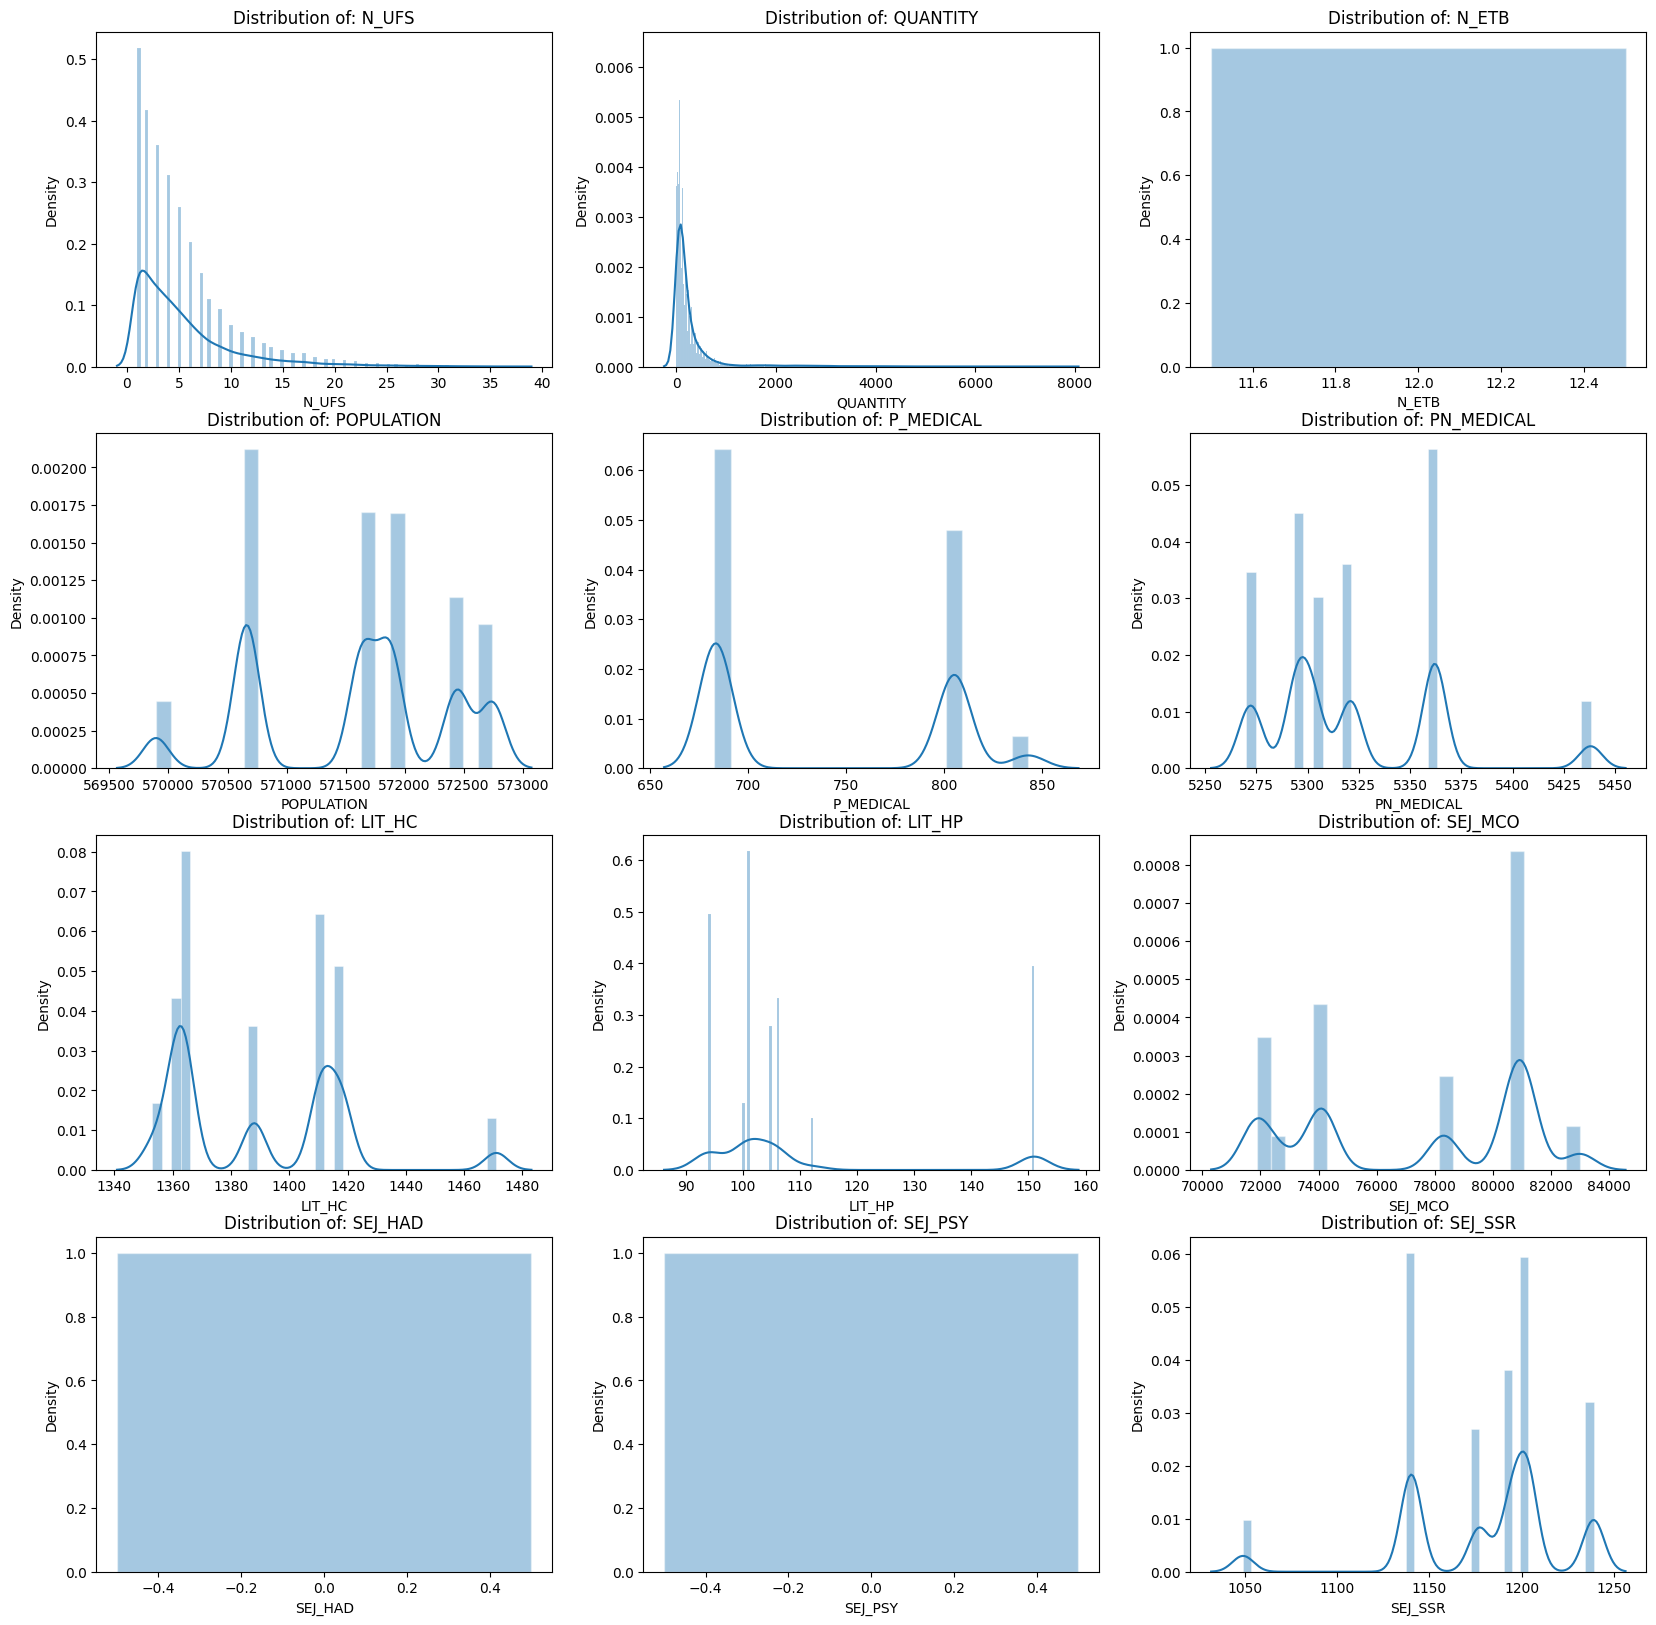

In [100]:
# Visualizing distribution after outlier removing
# Hospital 1
visualize_distribution(df_h1, numerical_features)

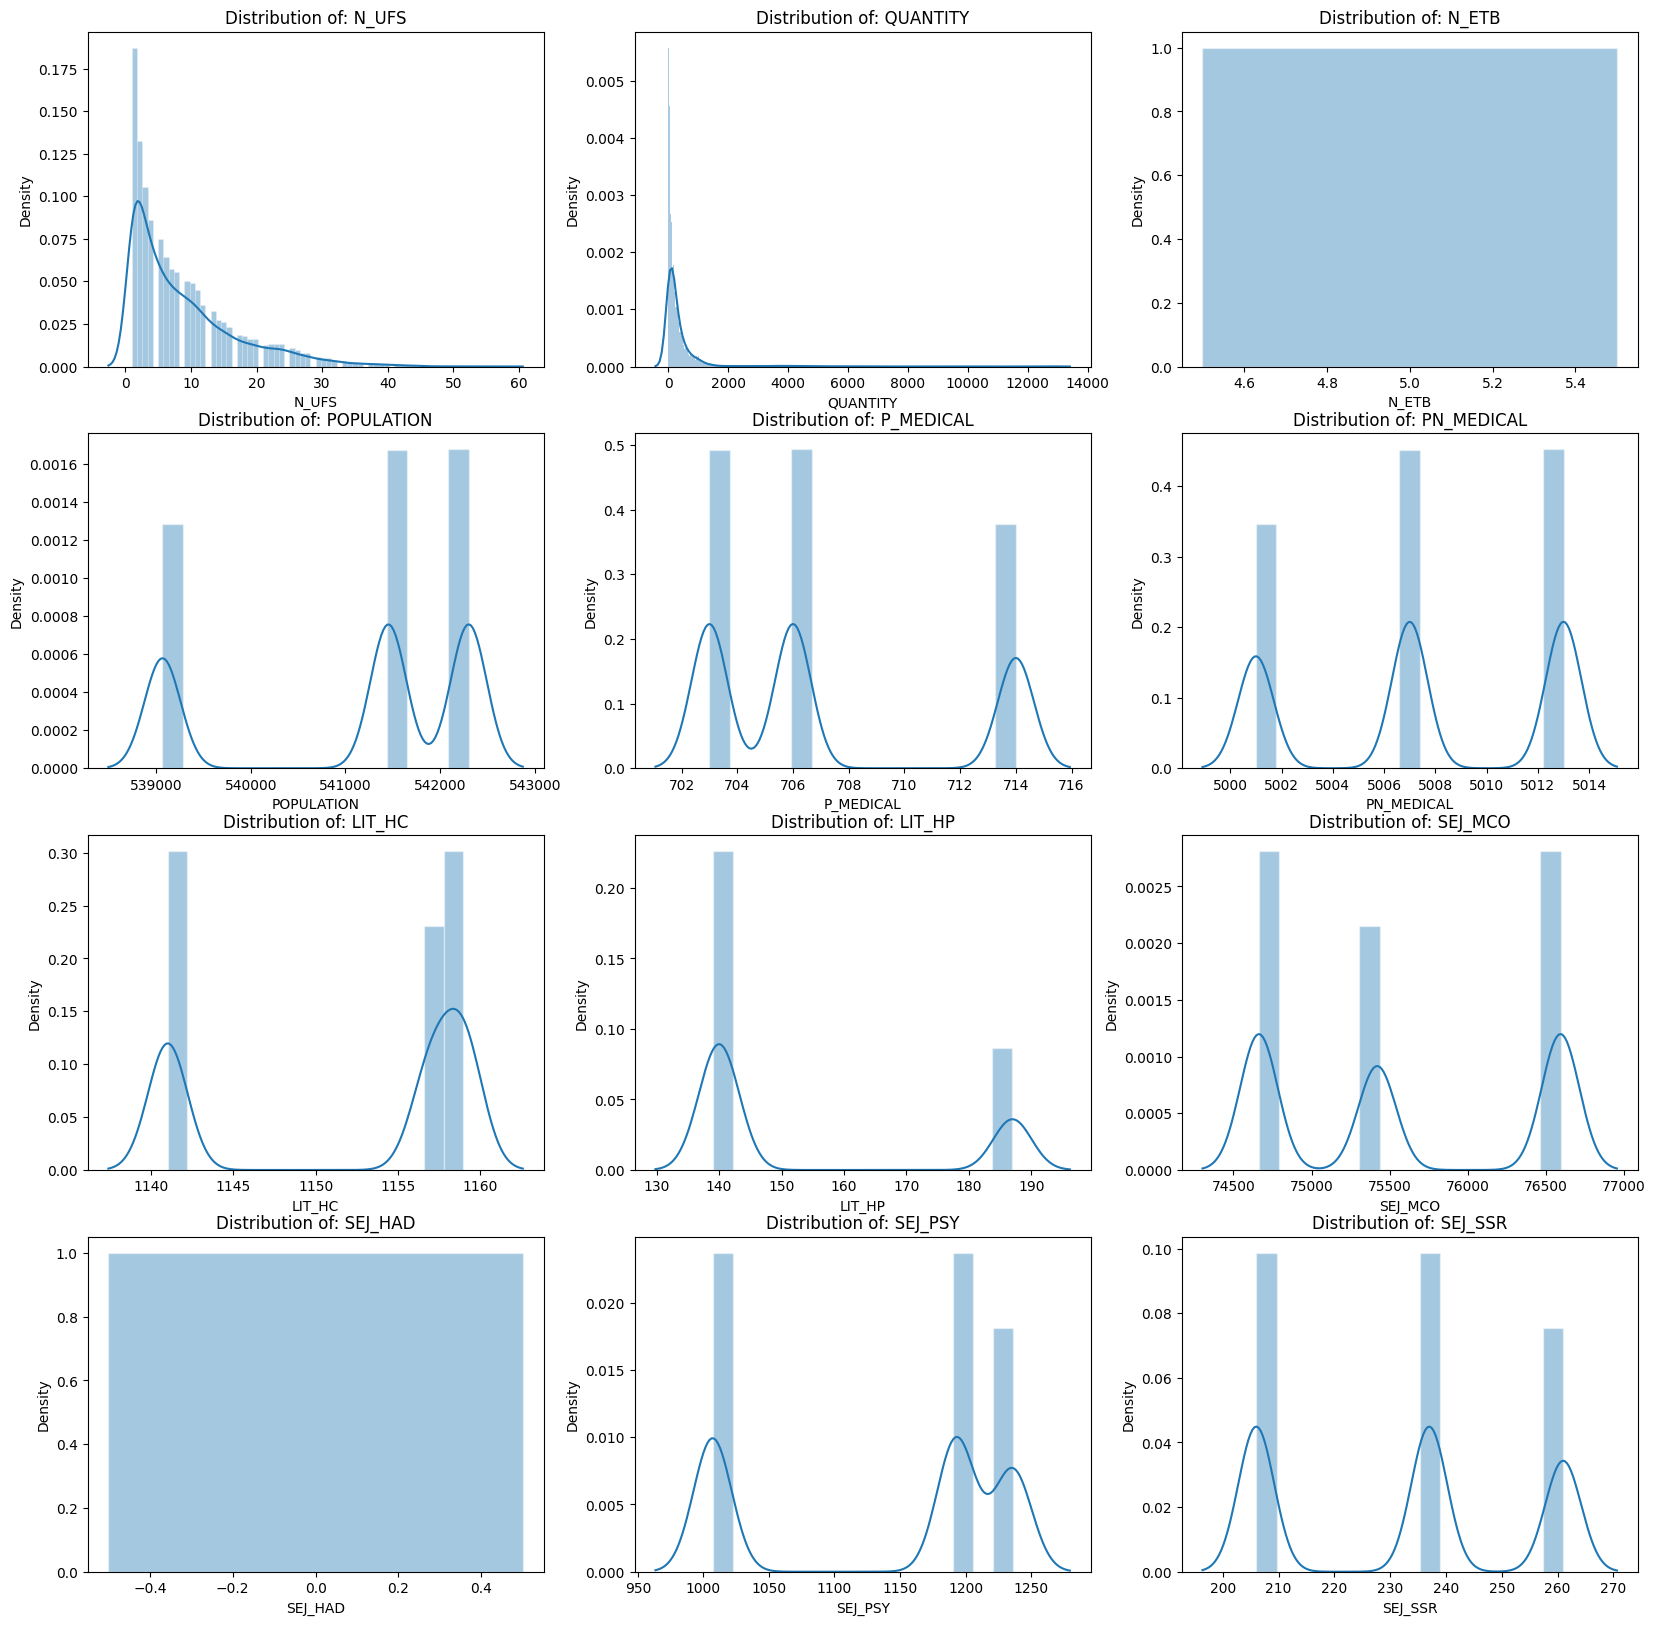

In [101]:
# Visualizing distribution after outlier removing
# Hospital 2
visualize_distribution(df_h2, numerical_features)

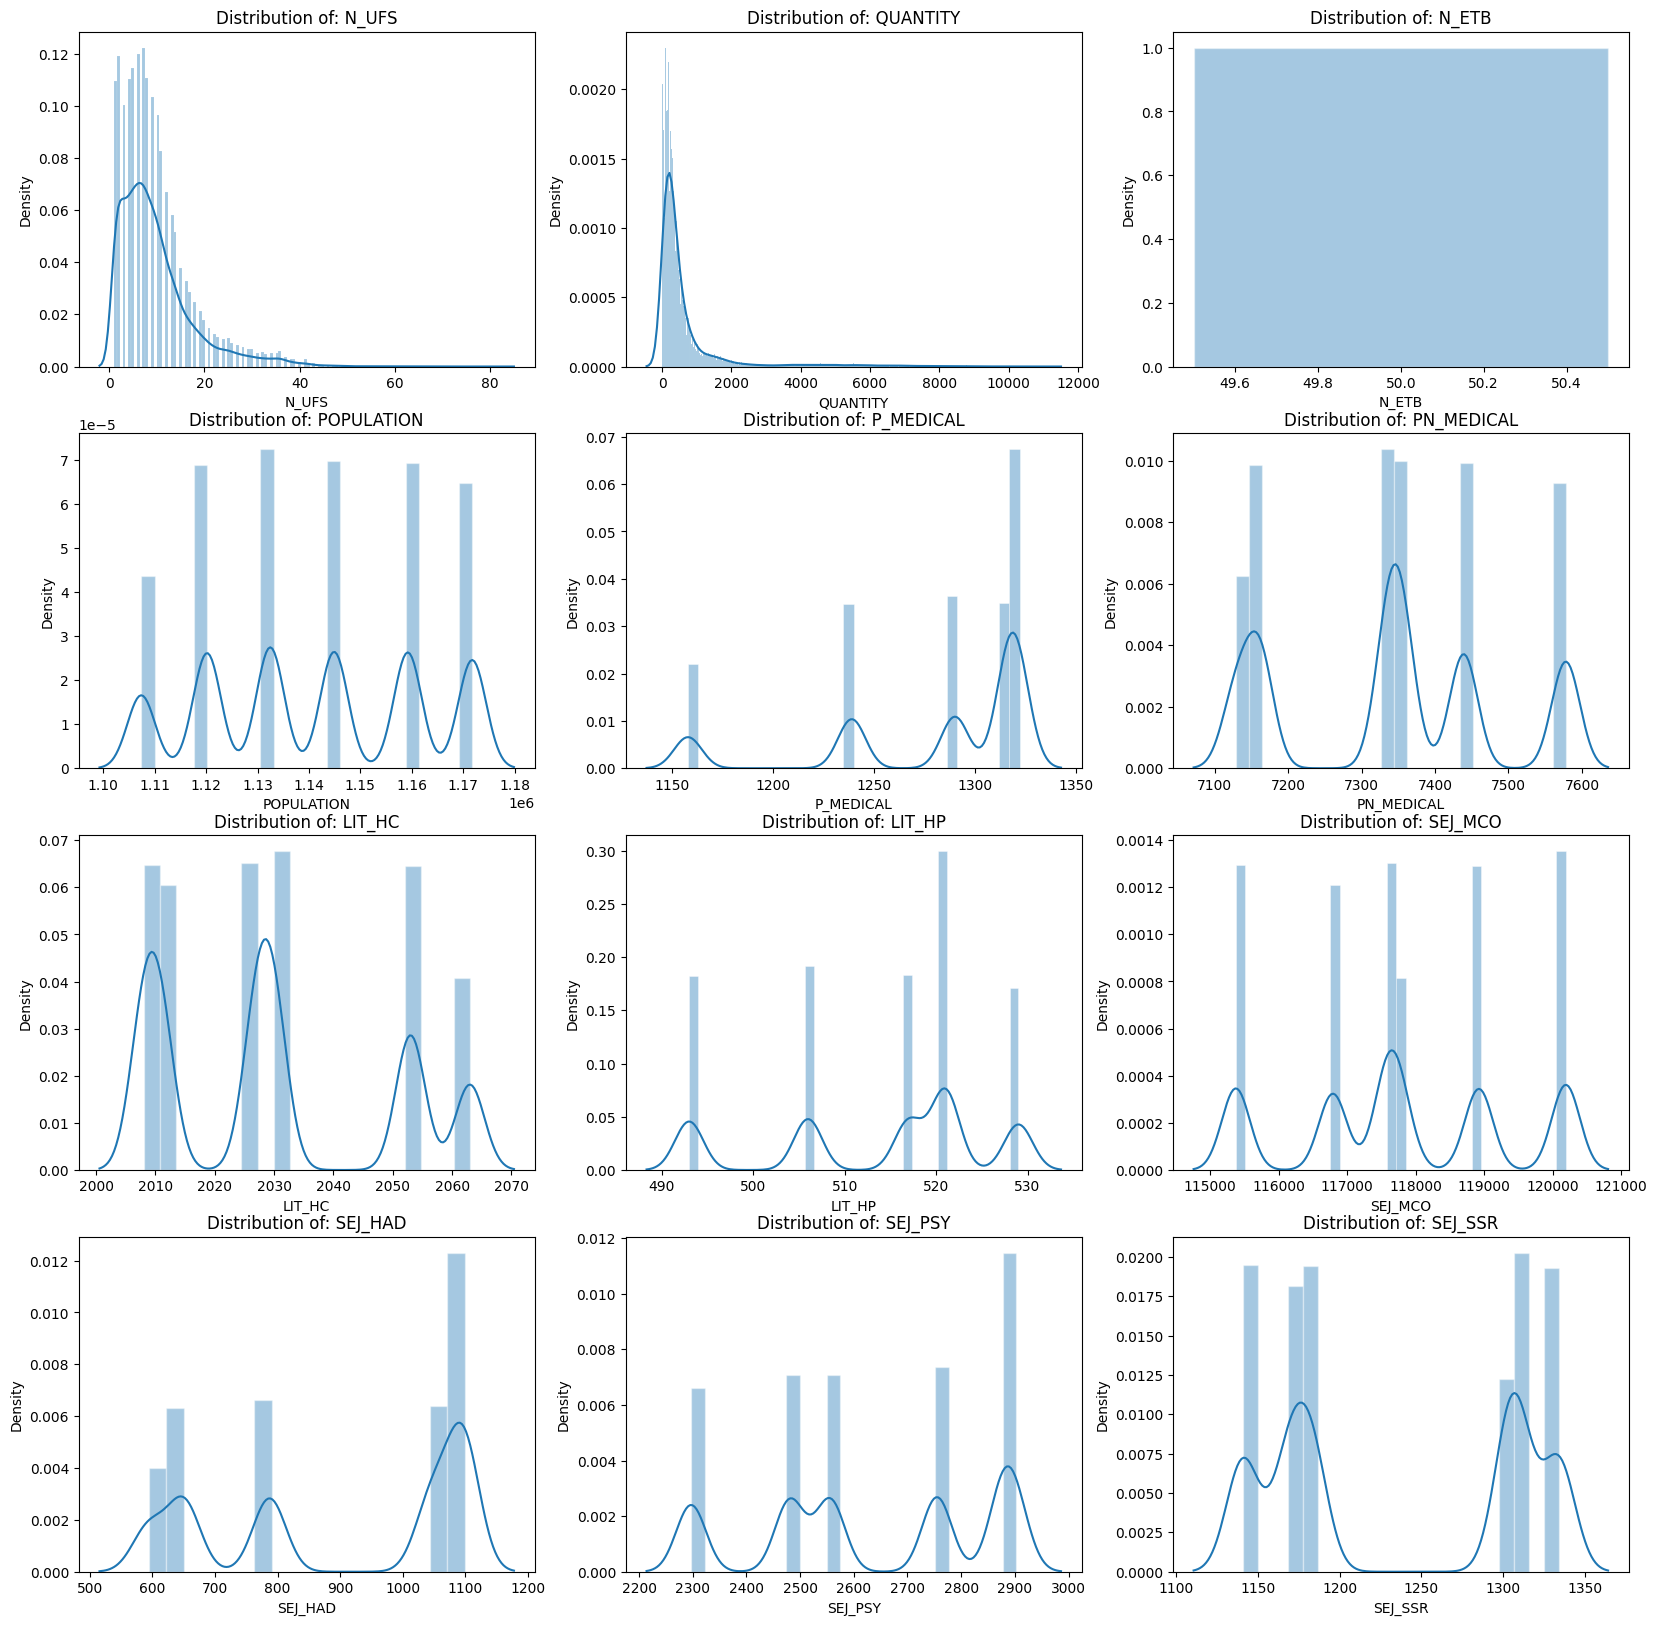

In [102]:
# Visualizing distribution after outlier removing
# Hospital 3
visualize_distribution(df_h3, numerical_features)

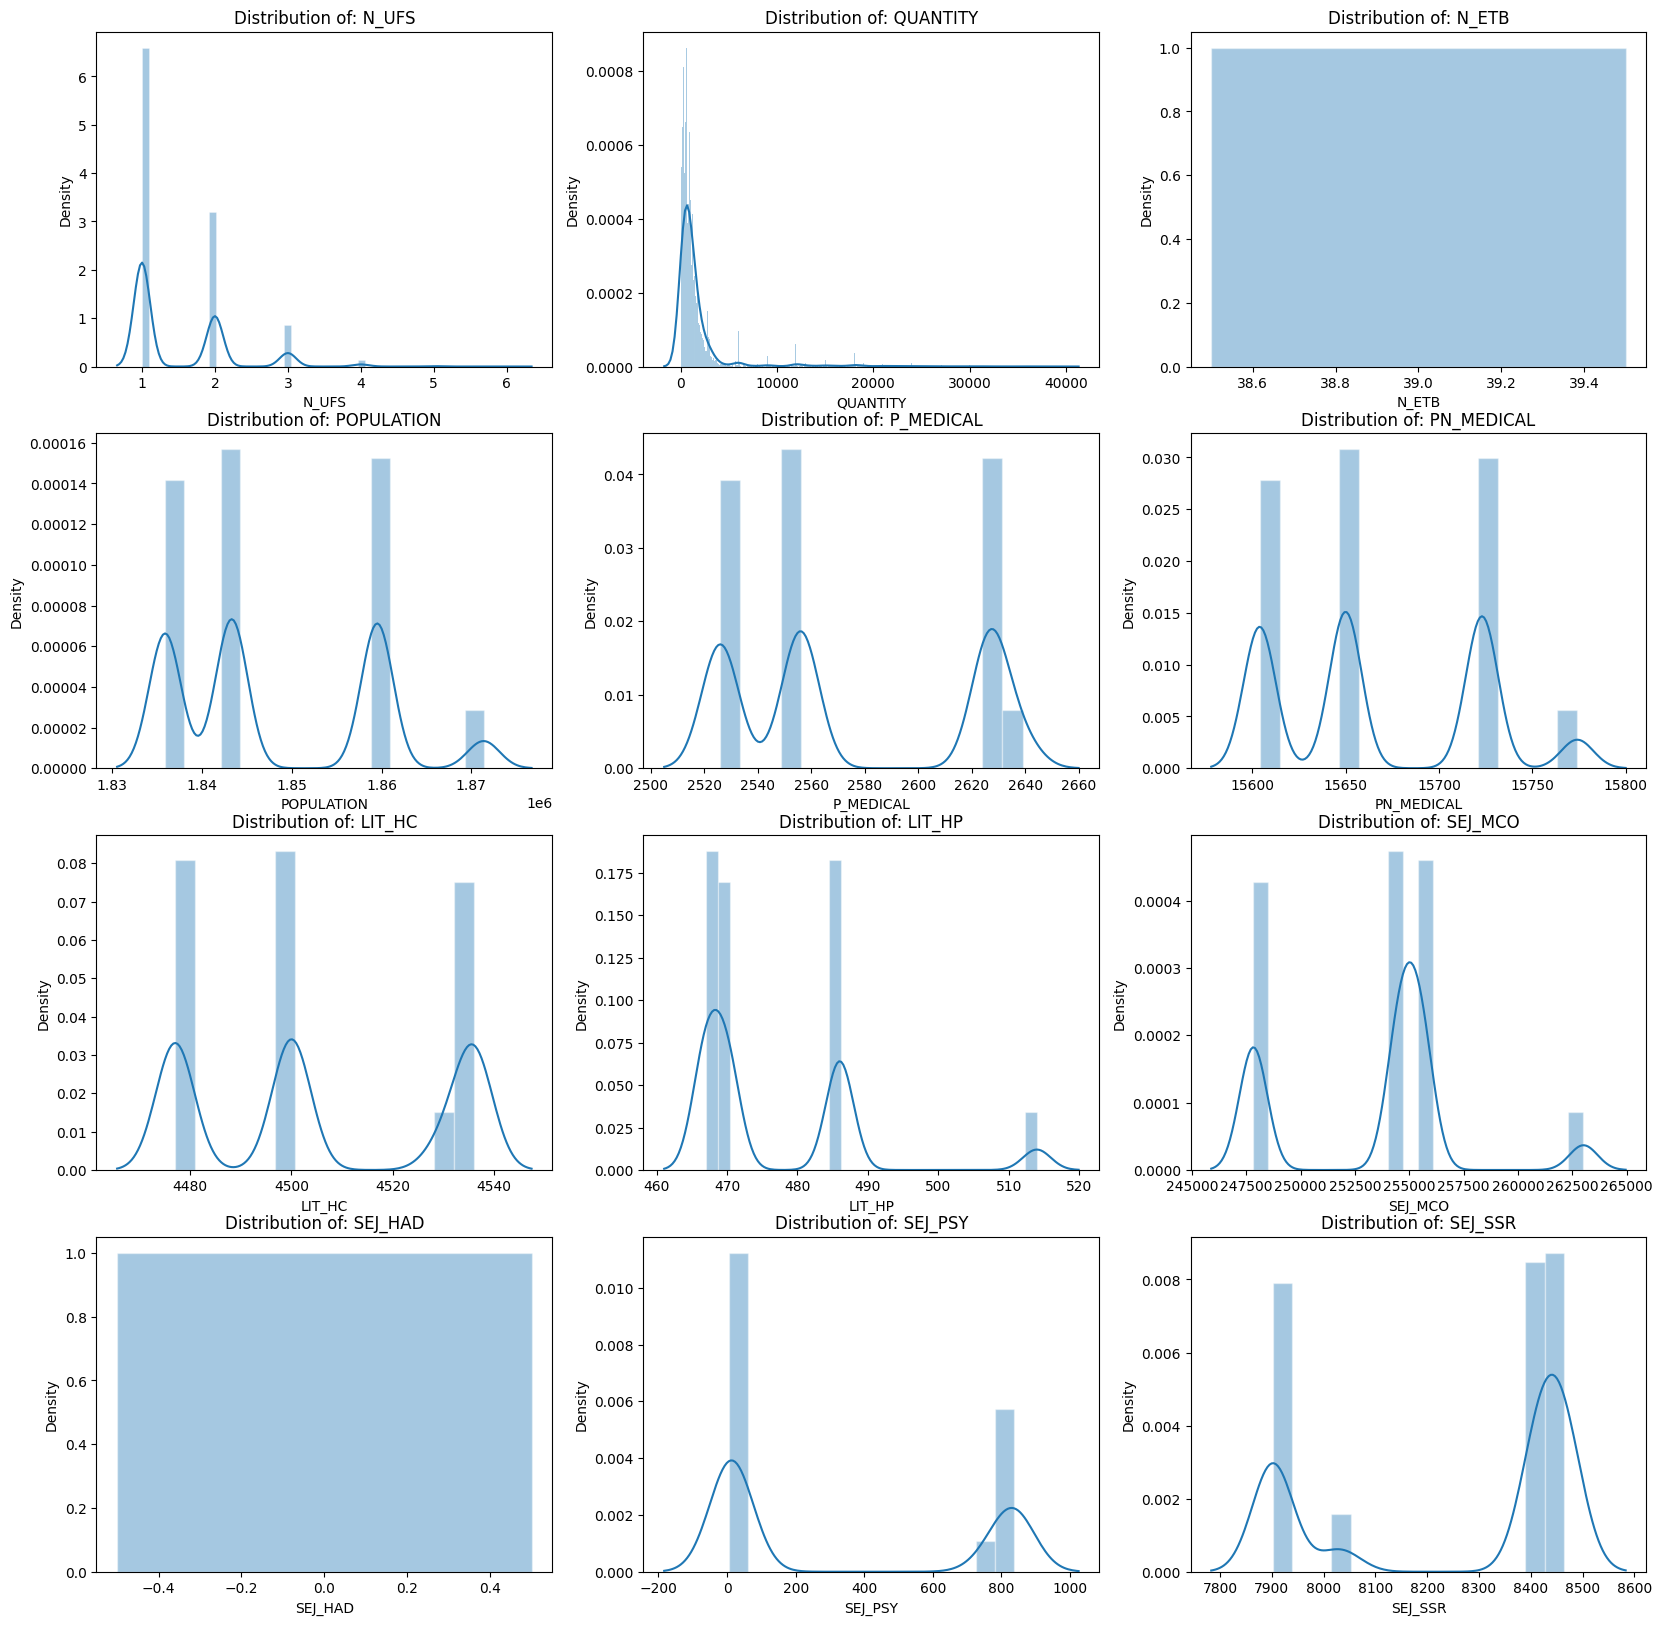

In [103]:
# Visualizing distribution after outlier removing
# Hospital 4
visualize_distribution(df_h4, numerical_features)

# Timeseries visualization

In [158]:
# Grouping the different datasets divided by hospital
df_grouped = pd.concat([df_h1, df_h2, df_h3, df_h4])
df_timeseries_plot = df_grouped[["YEAR", "MONTH","ID_REF","QUANTITY", "ID_SITE_RATTACHE"]].copy()

# Aggregating by "ID_REF", '"YEAR"', "MONTH", "ID_SITE_RATTACHE", summing the quantity
df_timeseries_plot = df_timeseries_plot.groupby(["ID_REF", "YEAR", "MONTH", "ID_SITE_RATTACHE"])['QUANTITY'].sum().reset_index()

# Sorting by date and drug
df_timeseries_plot.sort_values(by=['ID_REF', 'YEAR', 'MONTH'])
df_timeseries_plot.reset_index(drop=True)

# Changing the date display by year-month division
df_timeseries_plot['YEAR'] = df_timeseries_plot['YEAR'].astype(int)
df_timeseries_plot['MONTH'] = df_timeseries_plot['MONTH'].astype(int)
df_timeseries_plot['DATE'] = pd.to_datetime(df_timeseries_plot['YEAR'].astype(str) + '-' + df_timeseries_plot['MONTH'].astype(str), format='%Y-%m')


df_timeseries_plot = df_timeseries_plot[["ID_REF","ID_SITE_RATTACHE","DATE", "QUANTITY"]]

In [159]:
# Identifying a common period for the different timeseries
min_date_h1 = df_timeseries_plot[df_timeseries_plot["ID_SITE_RATTACHE"] == "HOSPI_1"]["DATE"].min()
min_date_h2 = df_timeseries_plot[df_timeseries_plot["ID_SITE_RATTACHE"] == "HOSPI_2"]["DATE"].min()
min_date_h3 = df_timeseries_plot[df_timeseries_plot["ID_SITE_RATTACHE"] == "HOSPI_3"]["DATE"].min()
min_date_h4 = df_timeseries_plot[df_timeseries_plot["ID_SITE_RATTACHE"] == "HOSPI_4"]["DATE"].min()

print(f'Min dates:' + f'\n H1: {min_date_h1}' + f'\n H2: {min_date_h2}' + f'\n H3: {min_date_h3}' + f'\n H4: {min_date_h4}')

max_date_h1 = df_timeseries_plot[df_timeseries_plot["ID_SITE_RATTACHE"] == "HOSPI_1"]["DATE"].max()
max_date_h2 = df_timeseries_plot[df_timeseries_plot["ID_SITE_RATTACHE"] == "HOSPI_2"]["DATE"].max()
max_date_h3 = df_timeseries_plot[df_timeseries_plot["ID_SITE_RATTACHE"] == "HOSPI_3"]["DATE"].max()
max_date_h4 = df_timeseries_plot[df_timeseries_plot["ID_SITE_RATTACHE"] == "HOSPI_4"]["DATE"].max()
print(f'\n Max dates:' + f'\n H1: {max_date_h1}' + f'\n H2: {max_date_h2}' + f'\n H3: {max_date_h3}' + f'\n H4: {max_date_h4}')

init = max(min_date_h1, min_date_h2, min_date_h3, min_date_h4)
ending = min(max_date_h1, max_date_h2, max_date_h3, max_date_h4)

print('\n')
print(f'Begin date: {init}')
print(f'End date: {ending}')


df_timeseries_plot = df_timeseries_plot[(df_timeseries_plot["DATE"]>= init)&(df_timeseries_plot["DATE"]<= end)]
df_timeseries_plot.head()


Min dates:
 H1: 2013-06-01 00:00:00
 H2: 2017-03-01 00:00:00
 H3: 2014-05-01 00:00:00
 H4: 2016-01-01 00:00:00

 Max dates:
 H1: 2019-12-01 00:00:00
 H2: 2019-12-01 00:00:00
 H3: 2019-12-01 00:00:00
 H4: 2019-03-01 00:00:00


Begin date: 2017-03-01 00:00:00
End date: 2019-03-01 00:00:00


ID_REF ID_SITE_RATTACHE       DATE  QUANTITY
14  20395          HOSPI_4 2017-03-01   21810.0
15  20395          HOSPI_4 2017-04-01   23040.0
16  20395          HOSPI_4 2017-05-01   30040.0
17  20395          HOSPI_4 2017-06-01   23260.0
18  20395          HOSPI_4 2017-07-01   21310.0

In [157]:
date_list = pd.date_range(start=init, end=ending, freq='MS').strftime('%Y-%m-%d').tolist()
medicines = set(df_timeseries_plot['ID_REF'].unique())

for date in date_list:
  medicines_in_day = set(list(df_timeseries_plot[df_timeseries_plot["DATE"] == date]["ID_REF"]))
  difference = medicines - medicines_in_day
  print(difference)
  for new_medicine in difference:
    if date == init:
      # Adding a new row for each medicine that is not present for the day
      new_row = {'ID_REF':new_medicine, 'ID_SITE_RATTACHE':"HOSPI_1", 'DATE':date, 'QUANTITY':0}
      df_timeseries_plot = df_timeseries_plot.append(new_row, ignore_index=True)

      new_row = {'ID_REF':new_medicine, 'ID_SITE_RATTACHE':"HOSPI_2", 'DATE':date, 'QUANTITY':0}
      df_timeseries_plot = df_timeseries_plot.append(new_row, ignore_index=True)

      new_row = {'ID_REF':new_medicine, 'ID_SITE_RATTACHE':"HOSPI_3", 'DATE':date, 'QUANTITY':0}
      df_timeseries_plot = df_timeseries_plot.append(new_row, ignore_index=True)

      new_row = {'ID_REF':new_medicine, 'ID_SITE_RATTACHE':"HOSPI_4", 'DATE':date, 'QUANTITY':0}
      df_timeseries_plot = df_timeseries_plot.append(new_row, ignore_index=True)
  break

{'890900', '9250856', '960491', '830701', '6180', '893880', '820070', '890228', '830303', '810359', '840051', '960148', '21099', '841268', '960388', '800851', '800852', '9373613', '890264', '830302', '960687', '822707', '830631', '891086', '9272958'}


In [153]:
A = {'a', 'b', 'c', '4'}
B = {'a', 'c'}
C = A - B

for i in C:
  print(i)


b
4


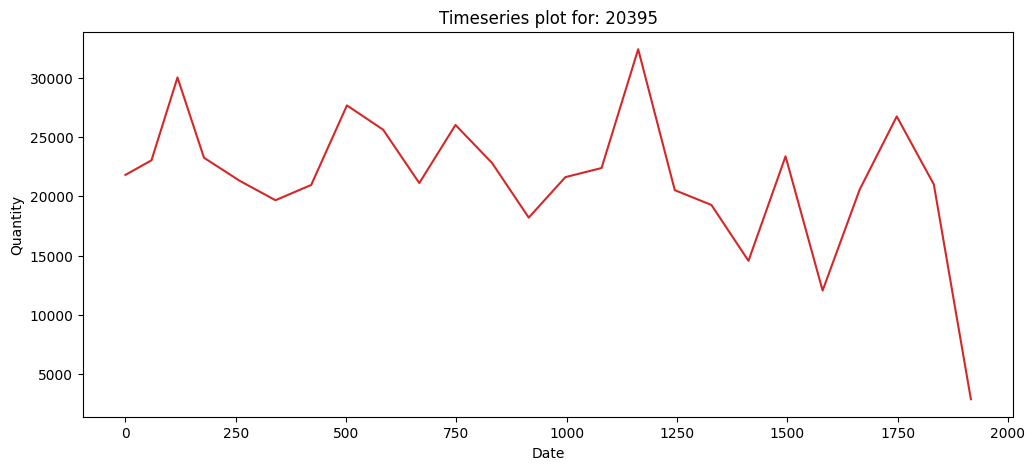

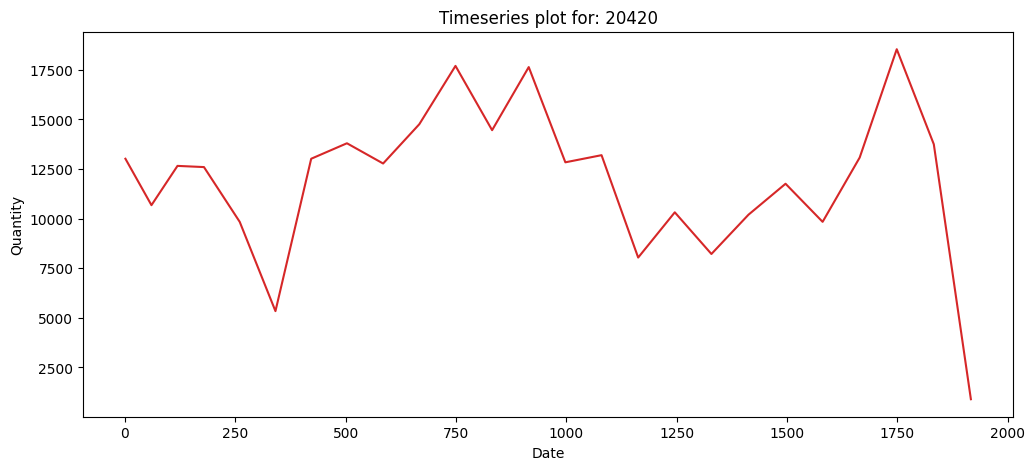

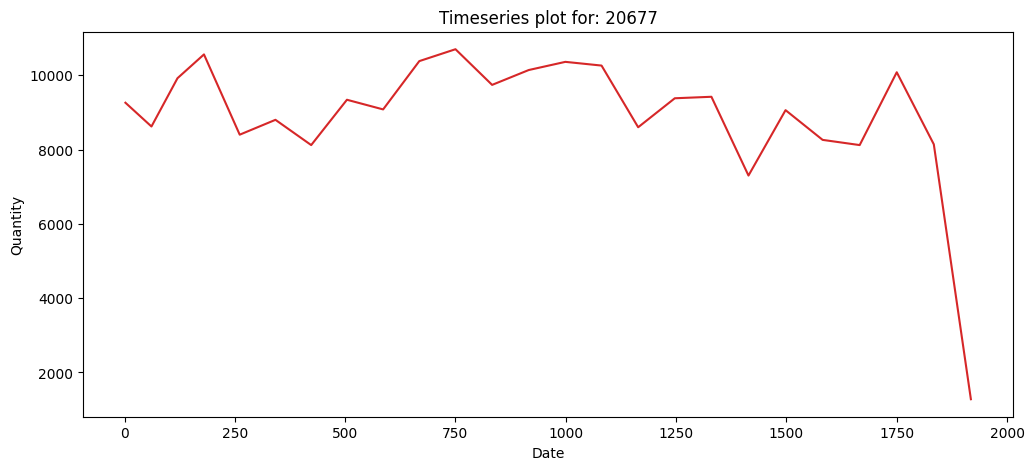

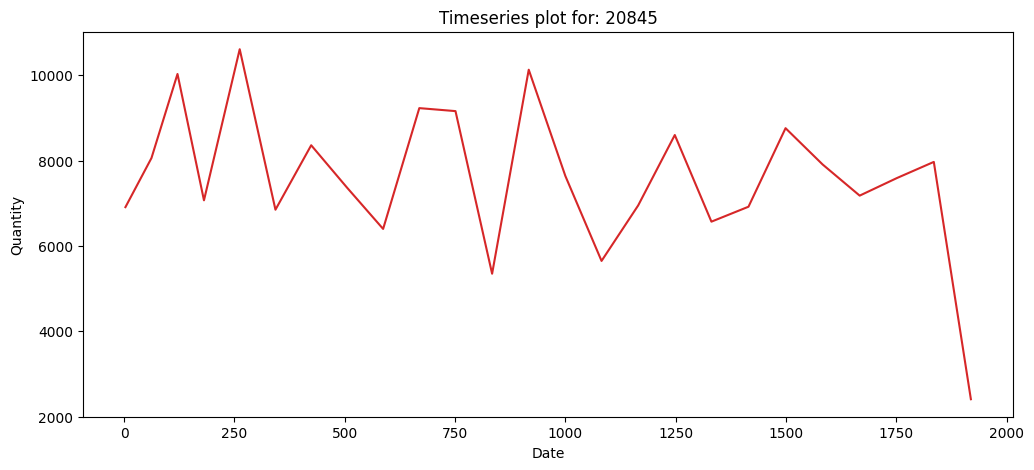

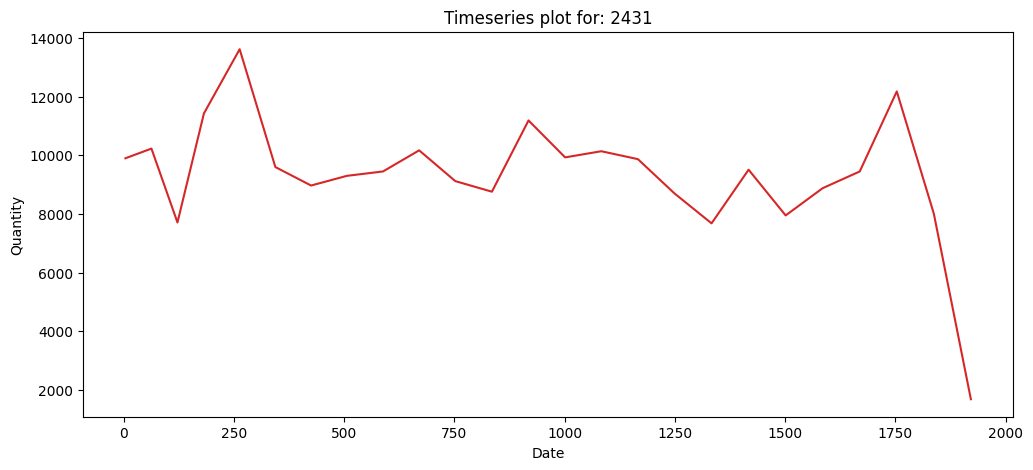

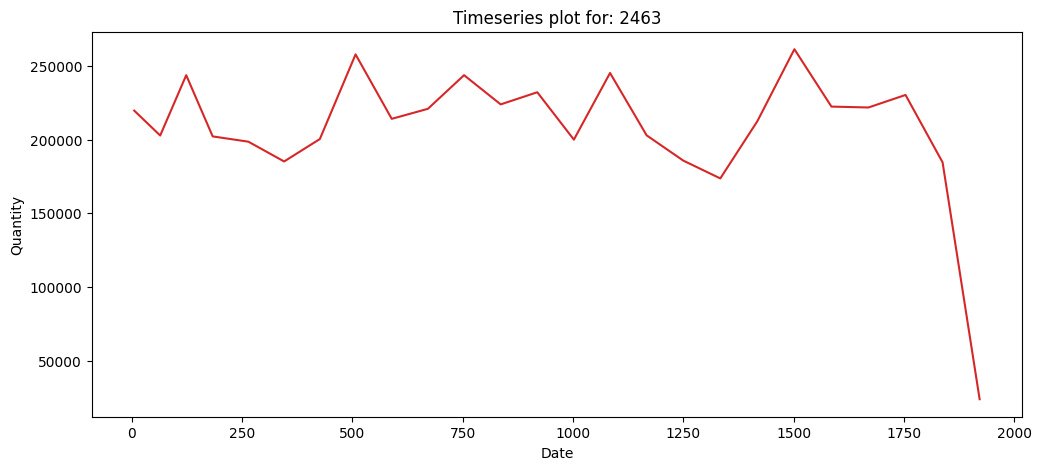

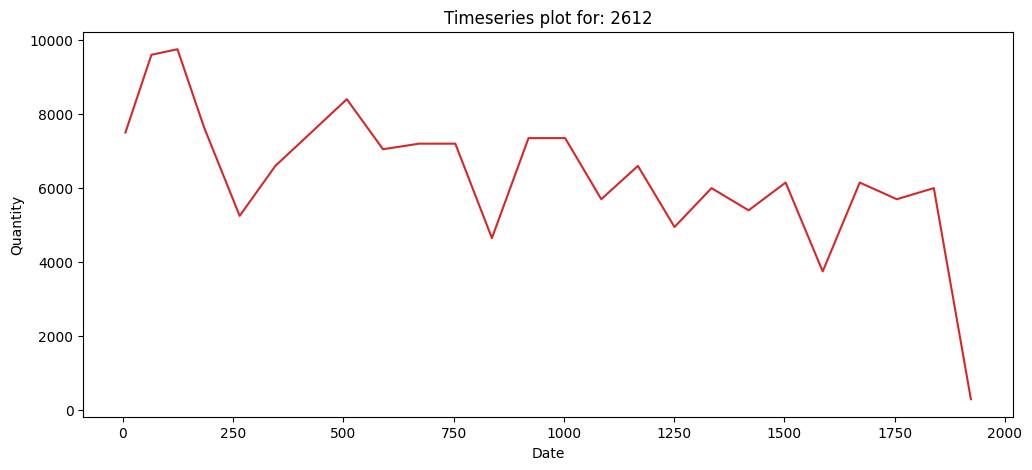

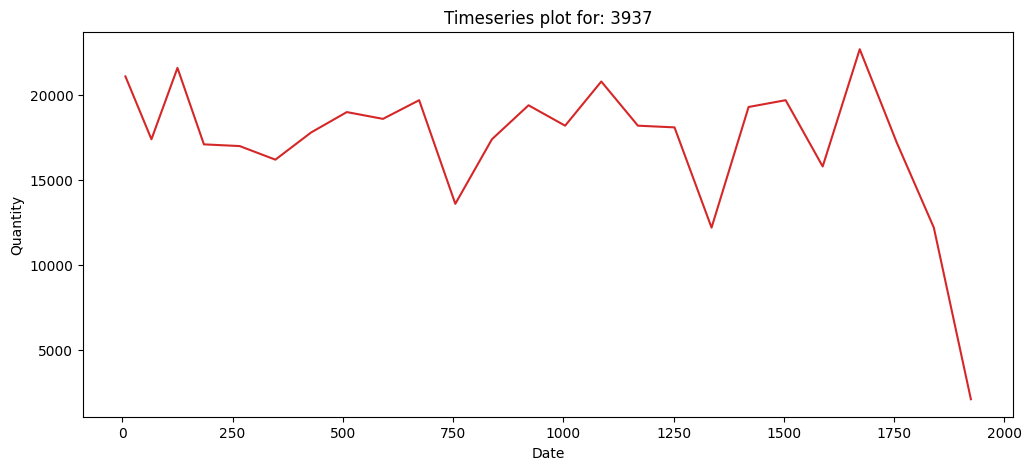

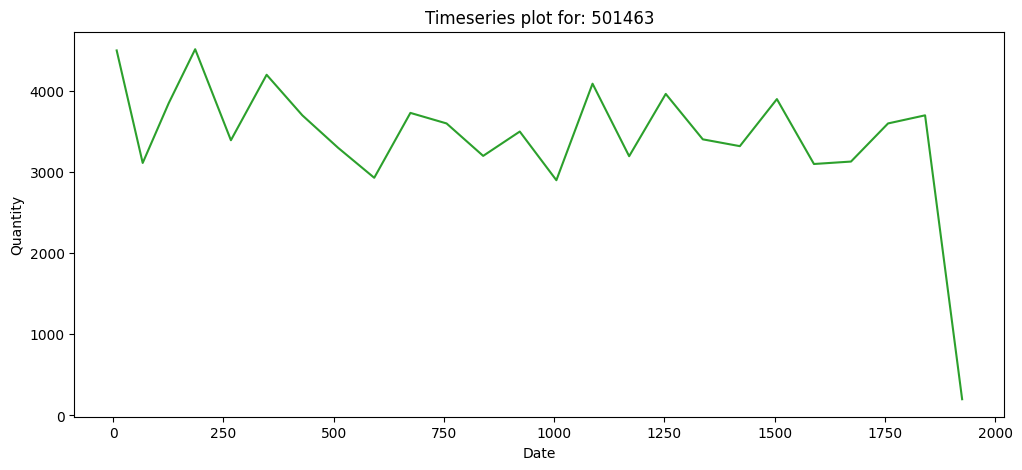

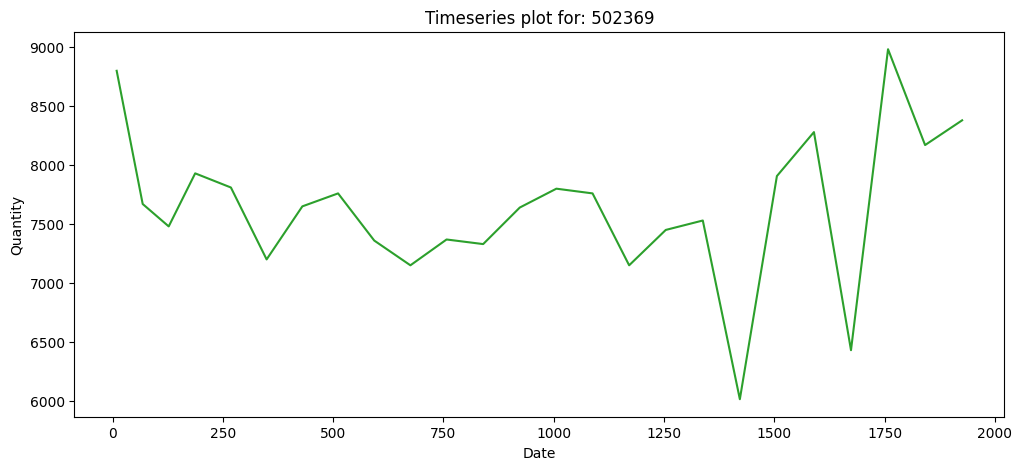

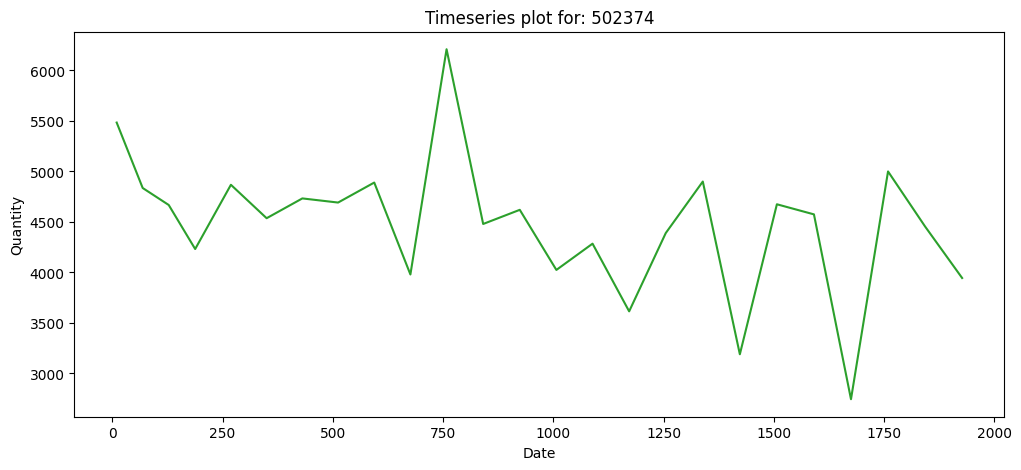

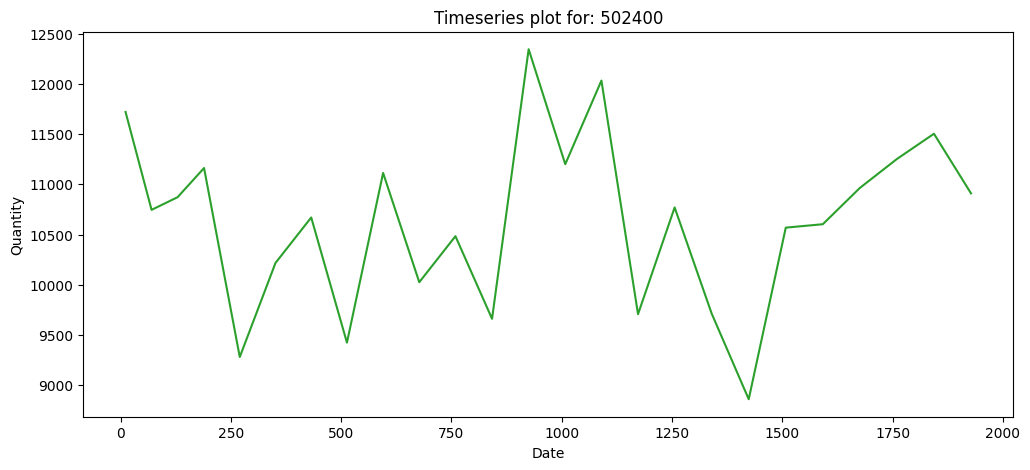

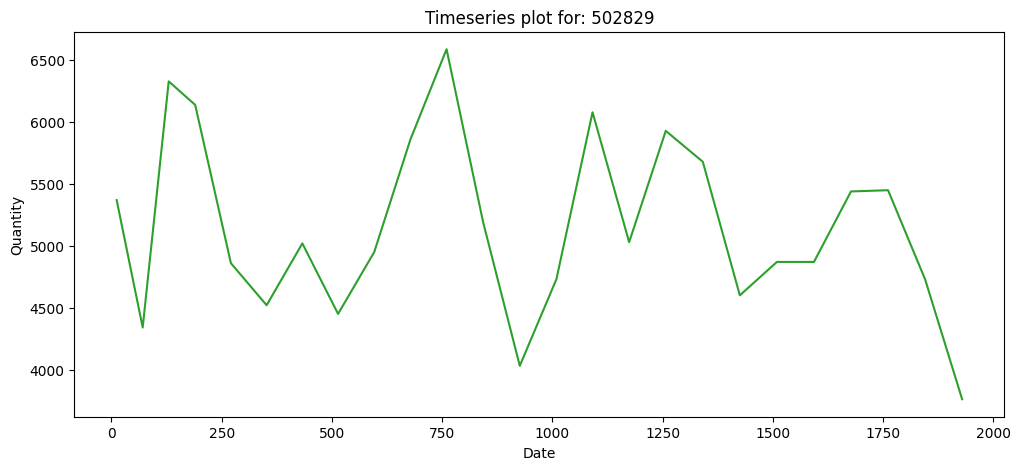

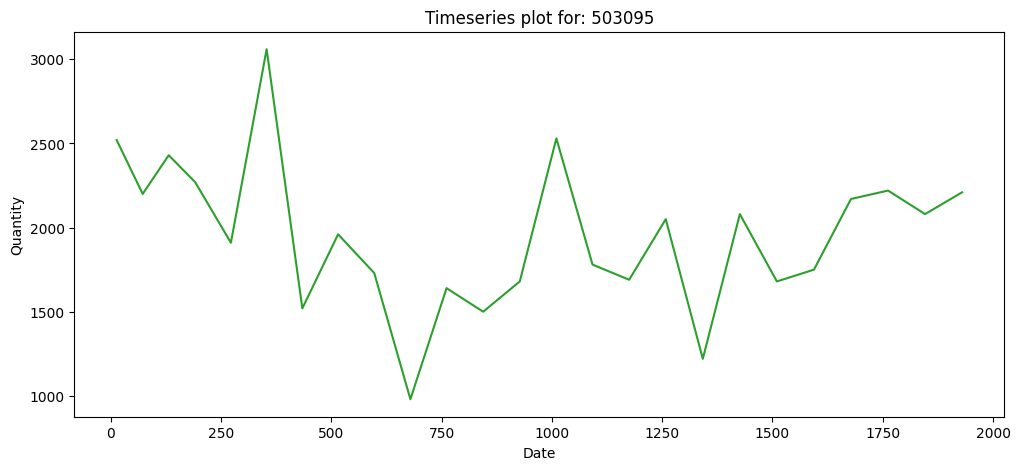

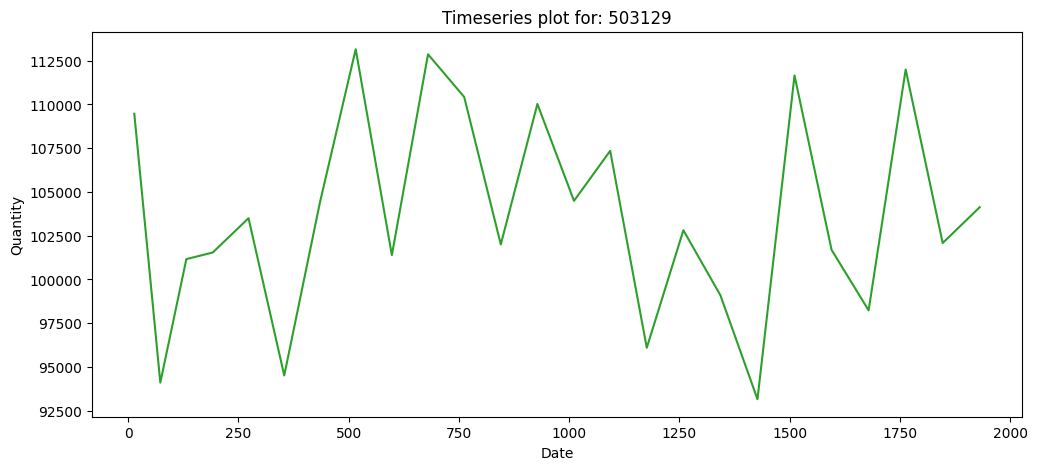

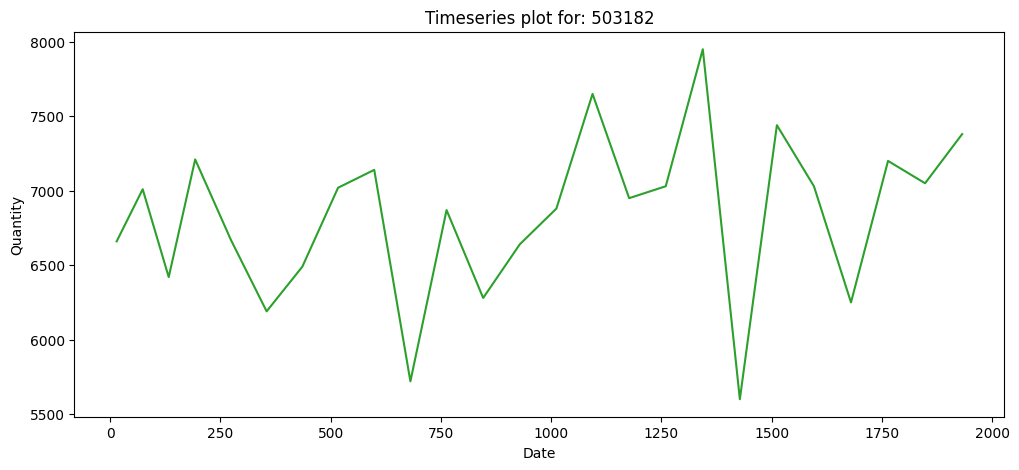

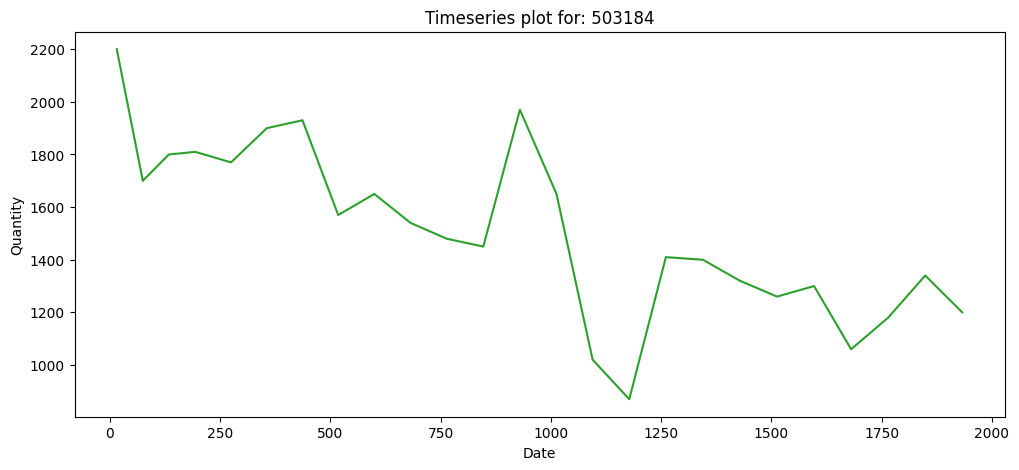

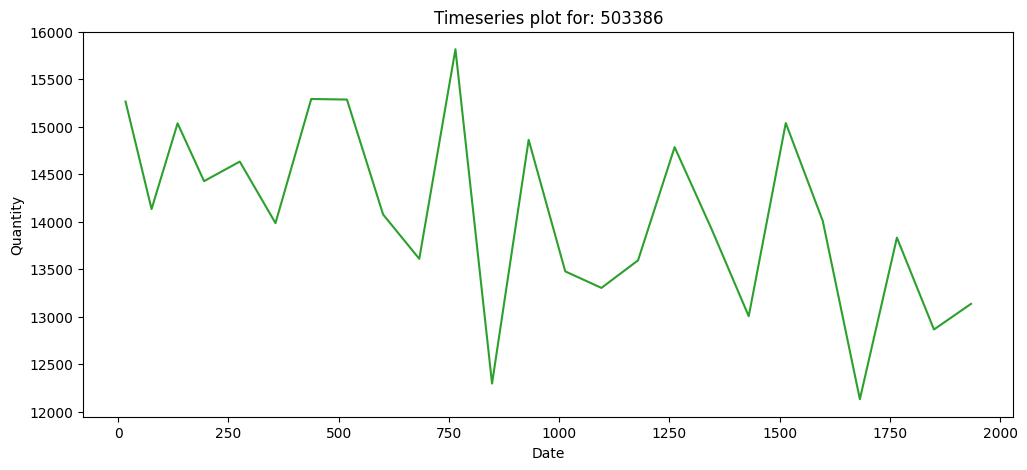

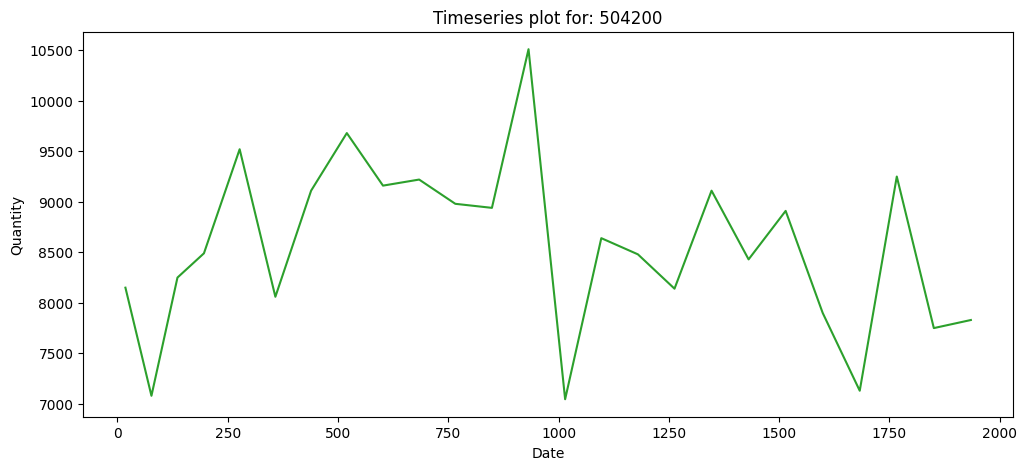

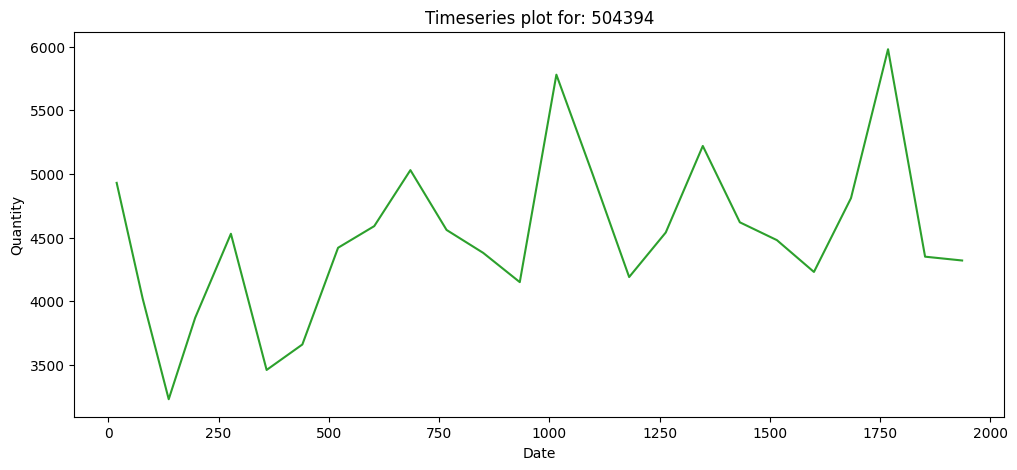

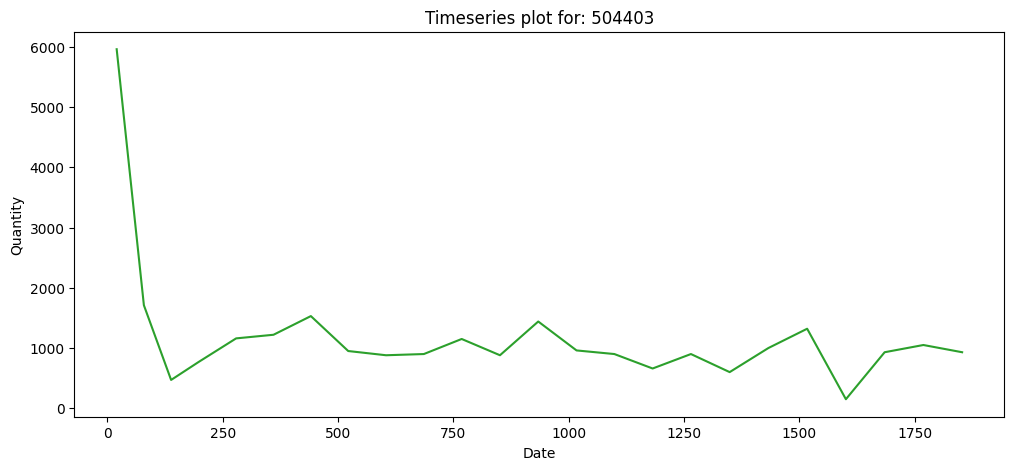

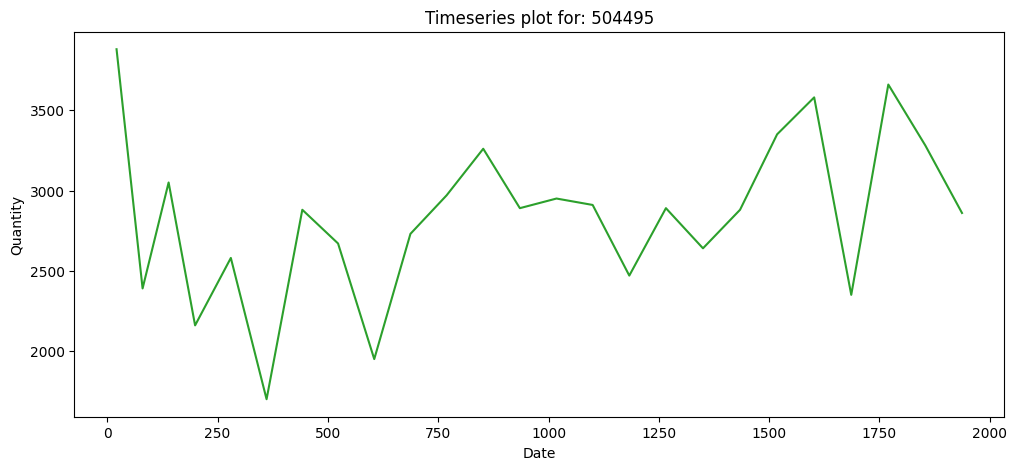

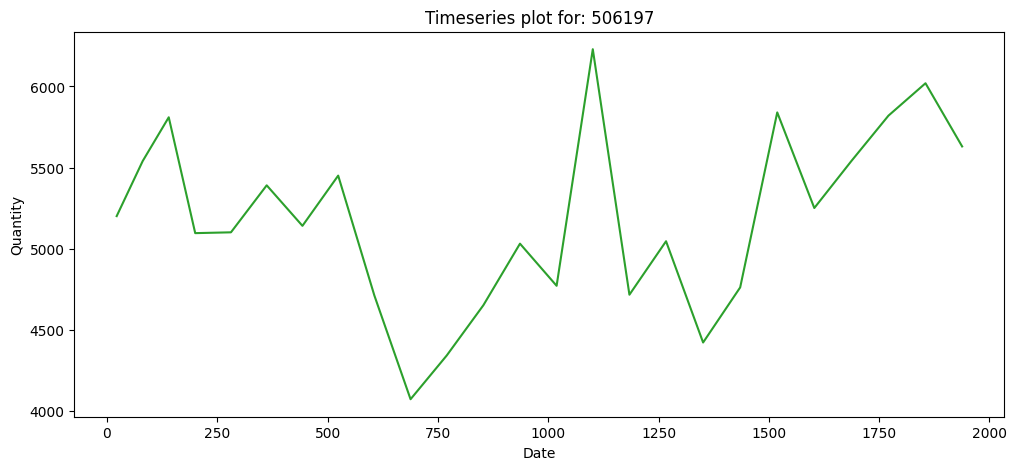

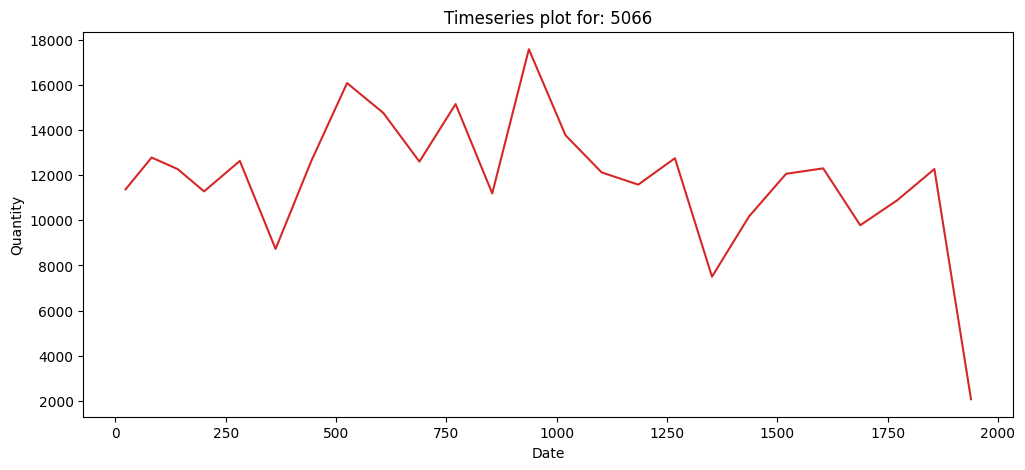

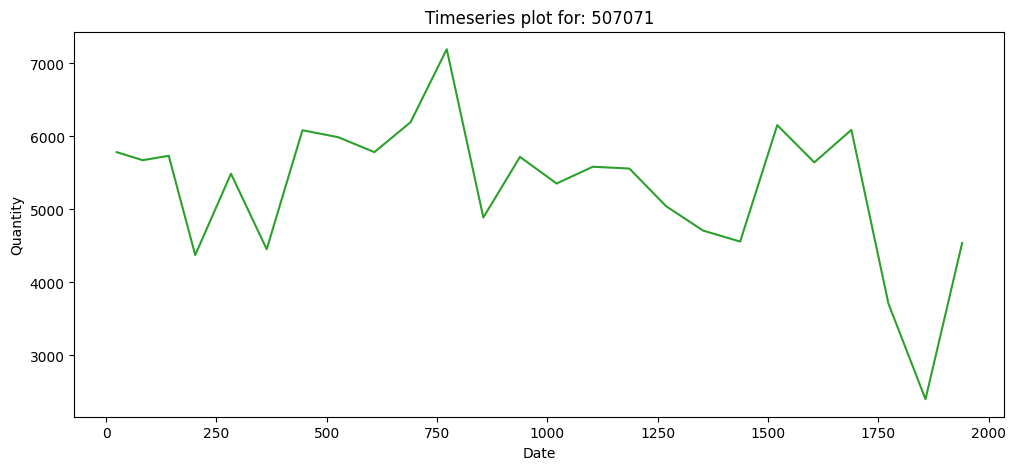

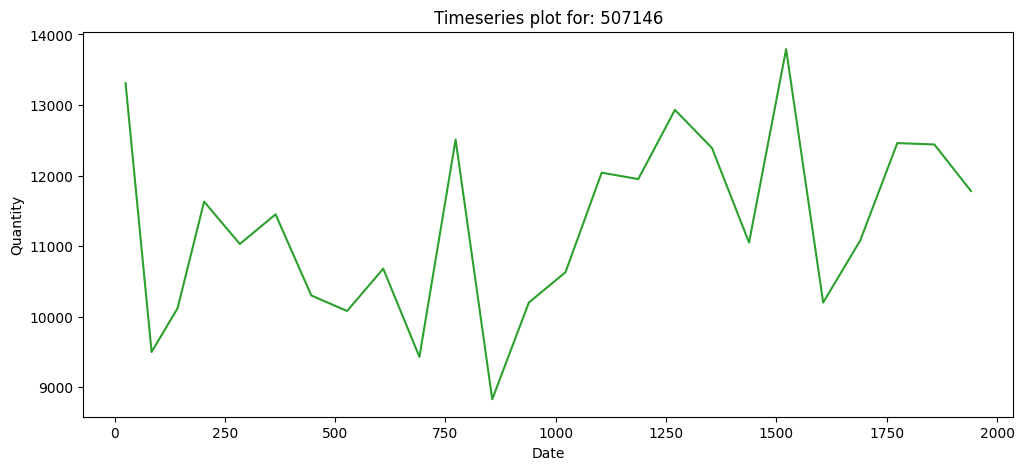

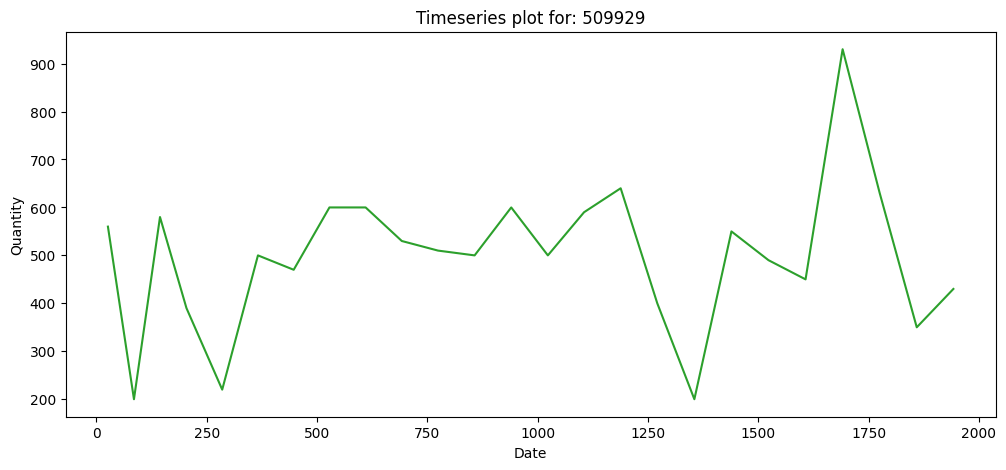

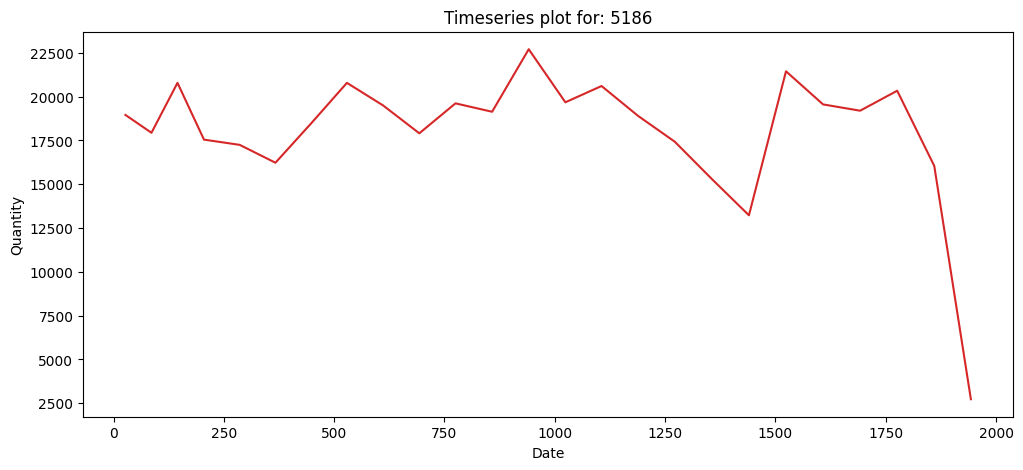

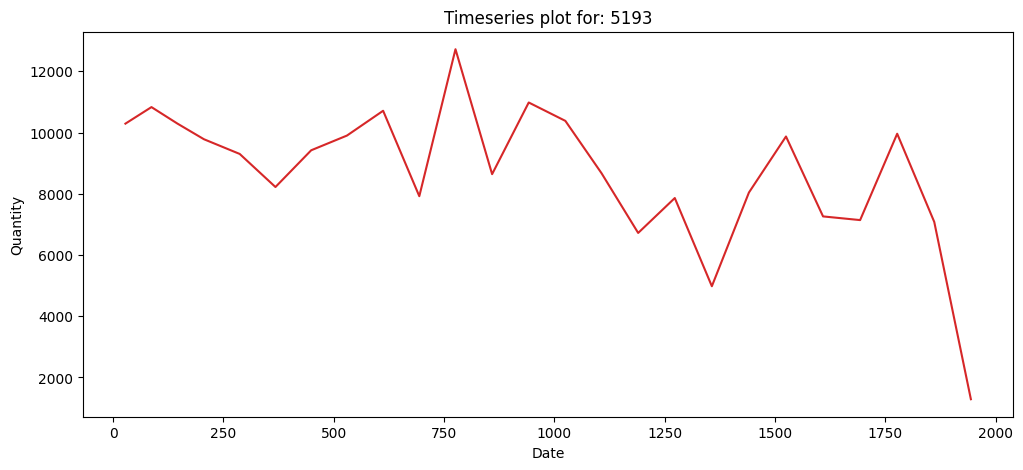

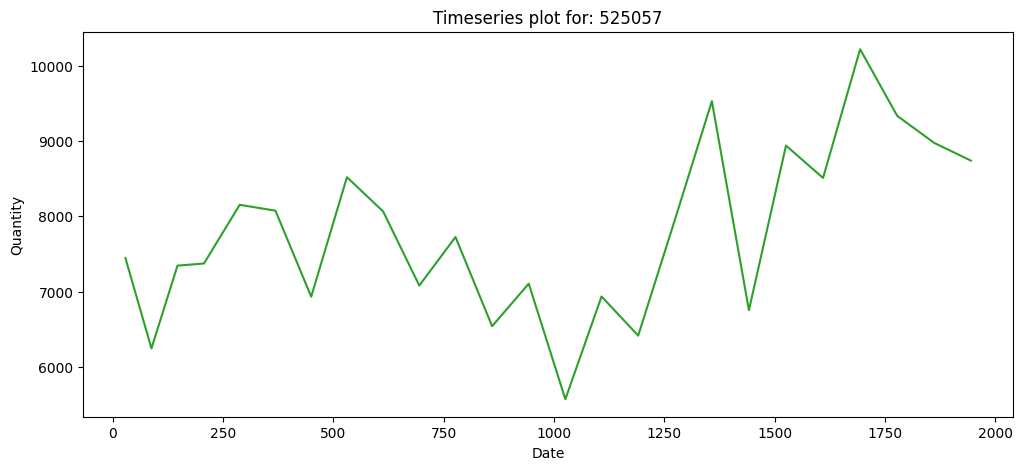

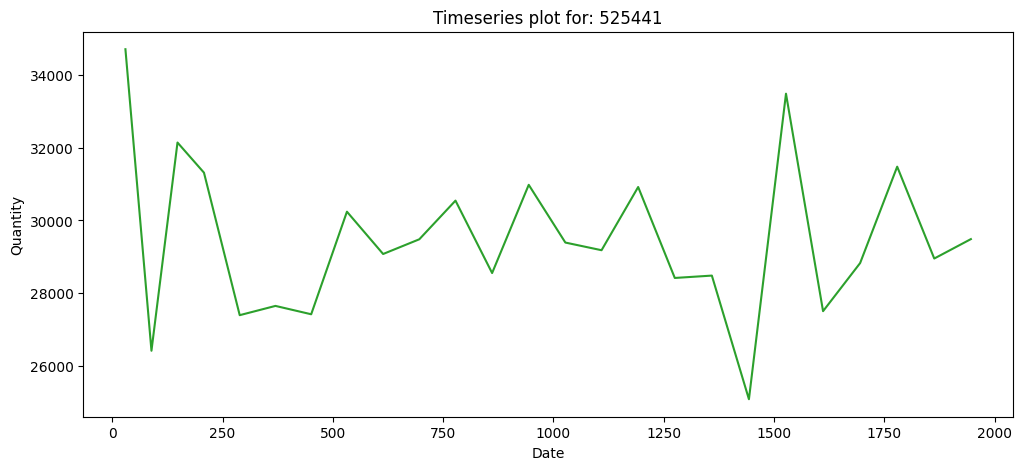

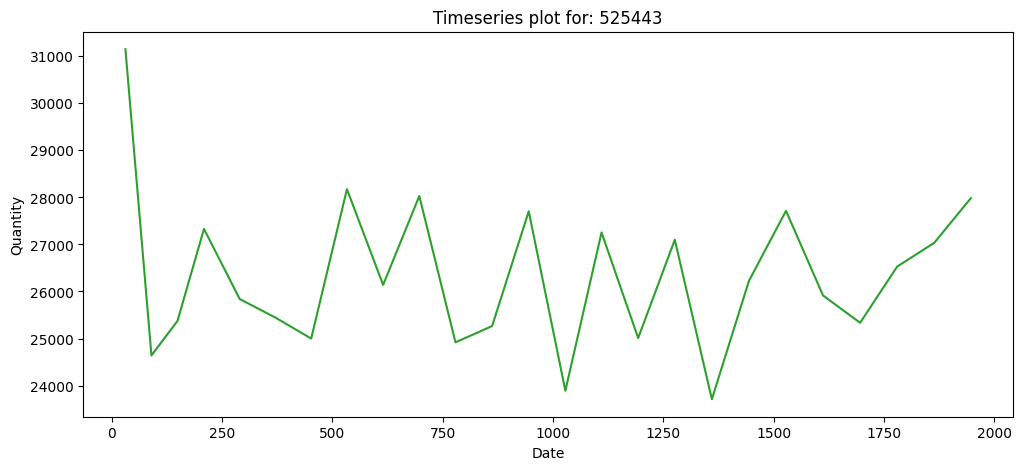

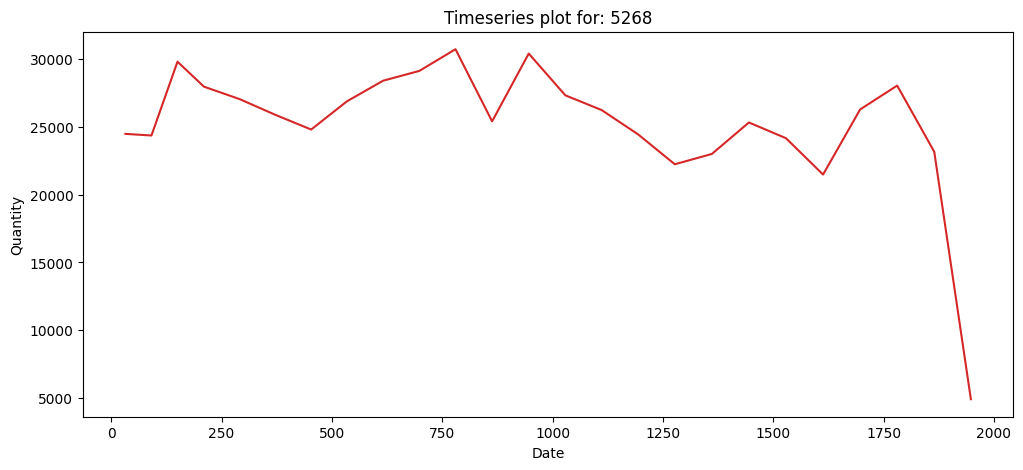

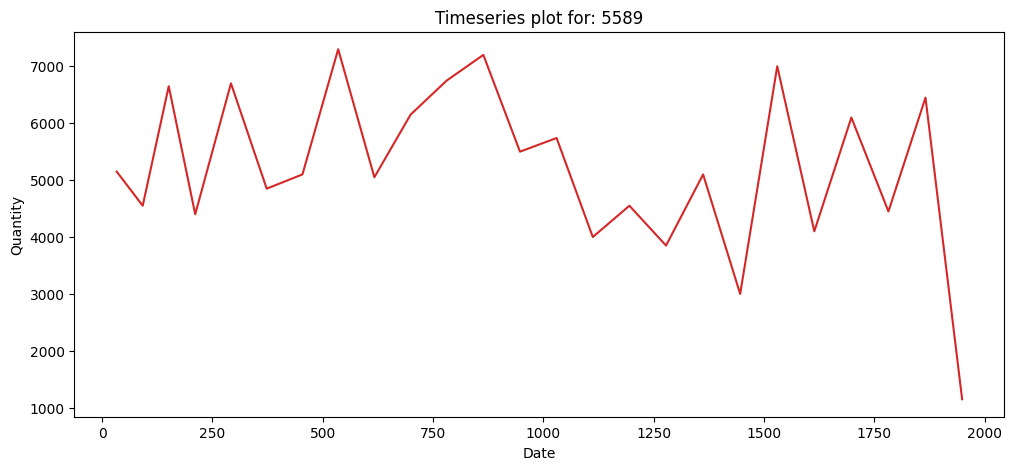

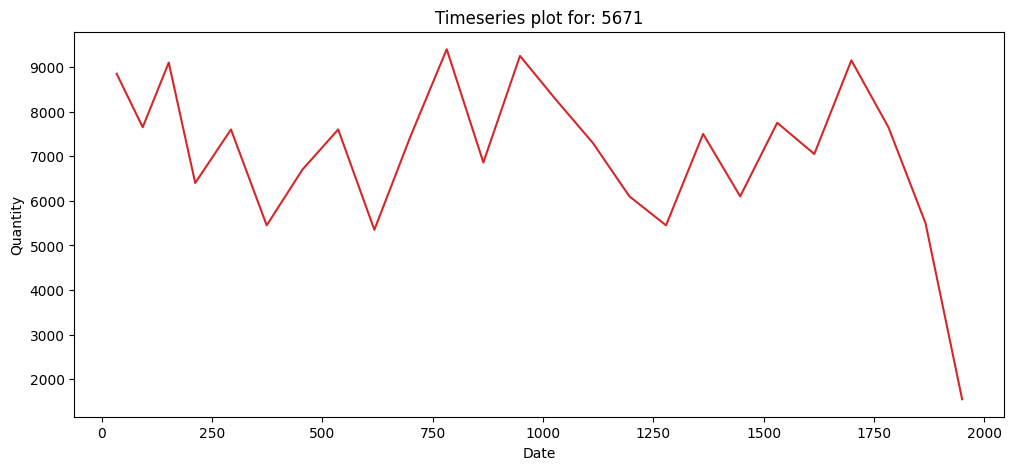

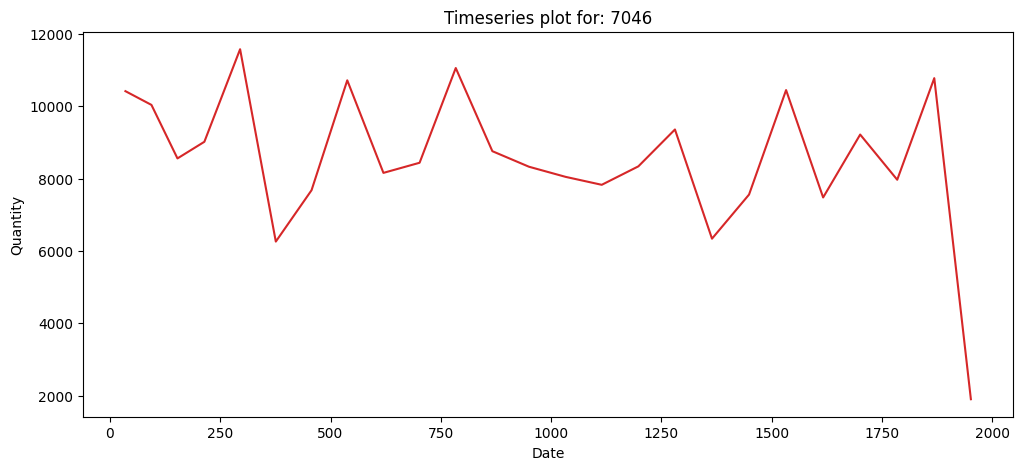

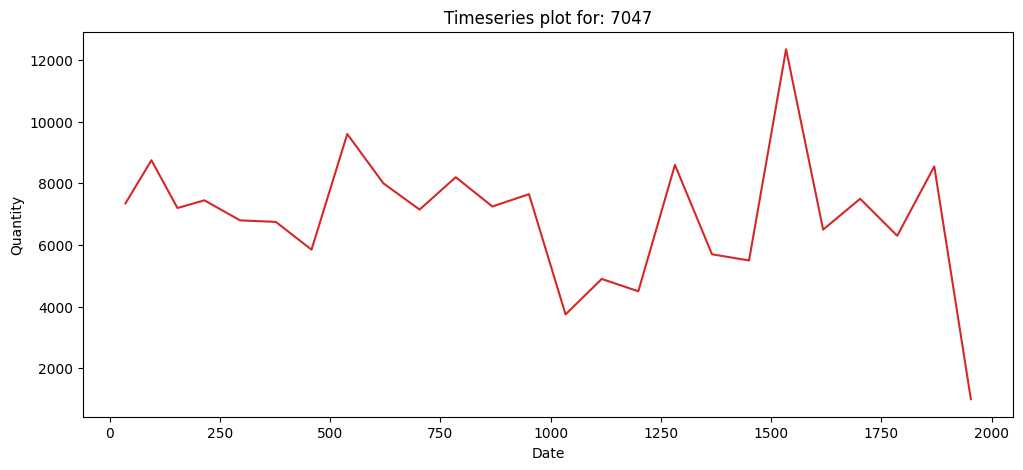

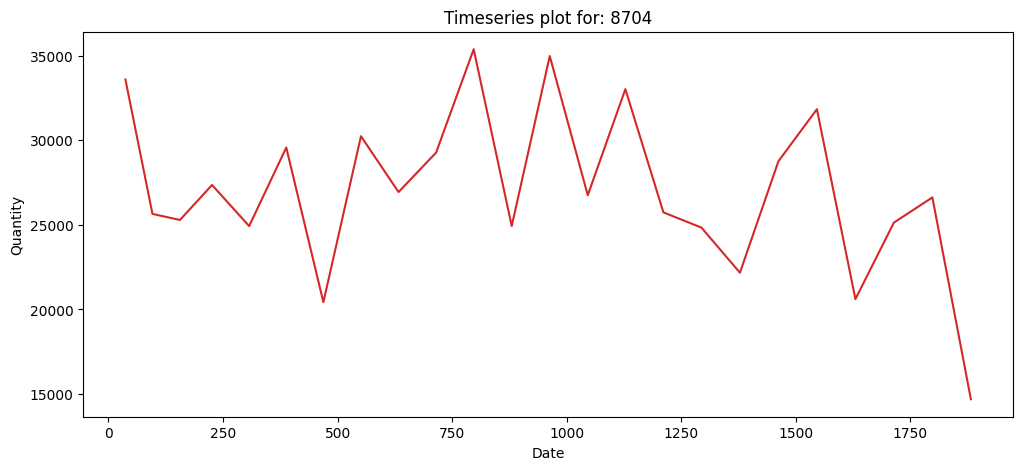

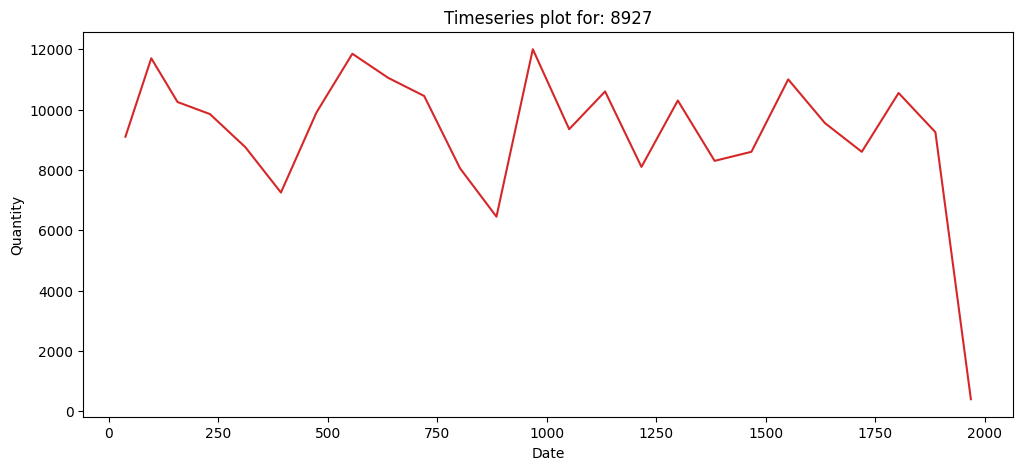

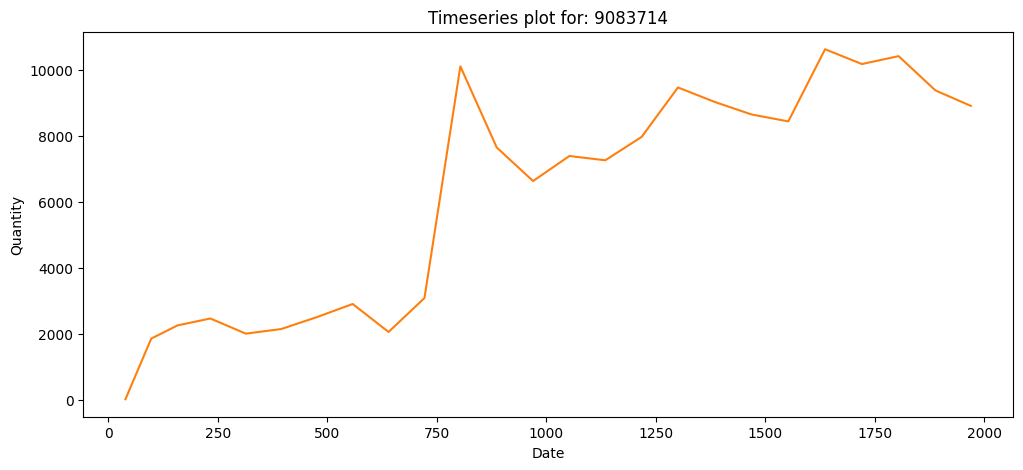

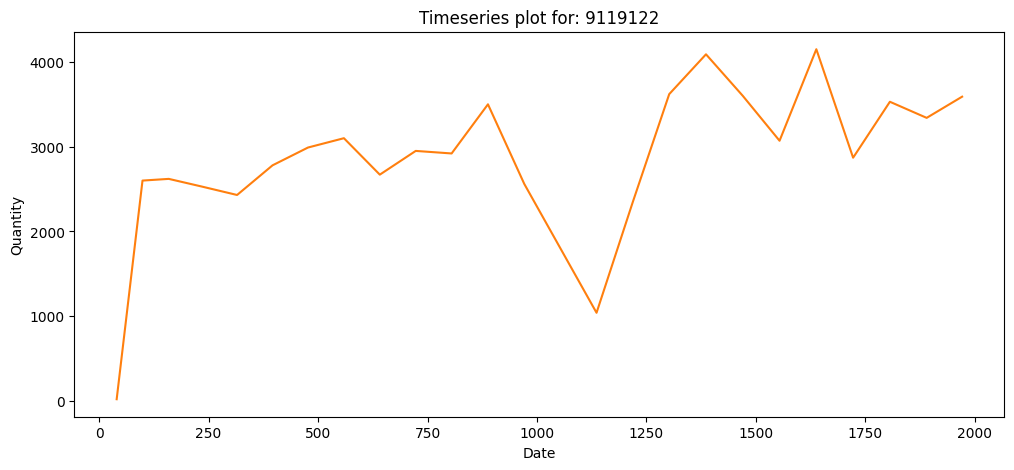

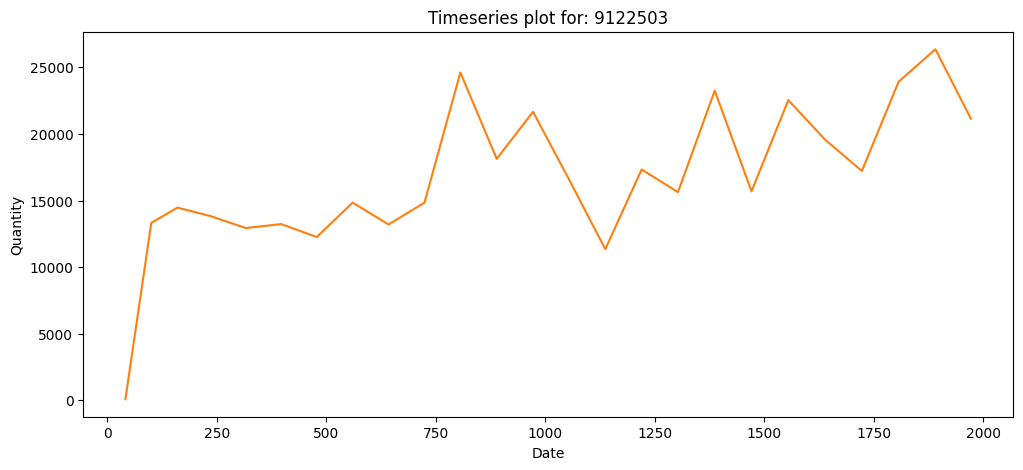

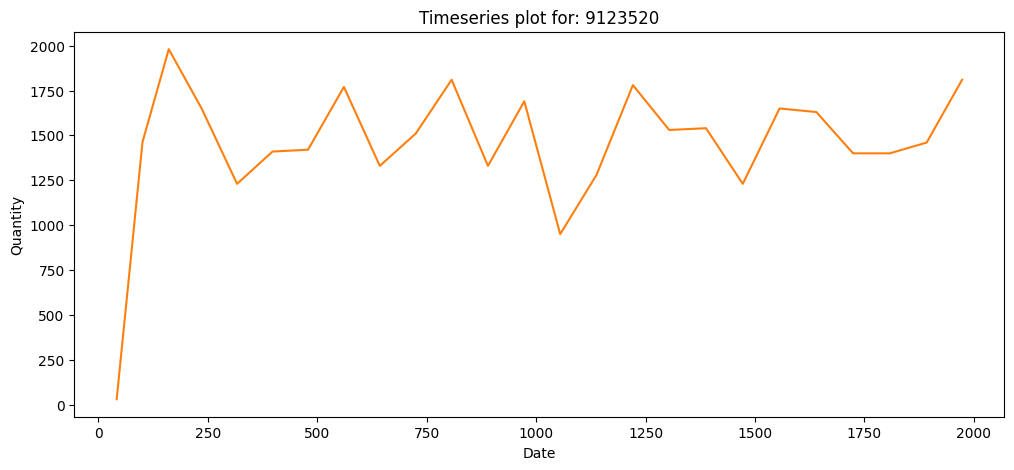

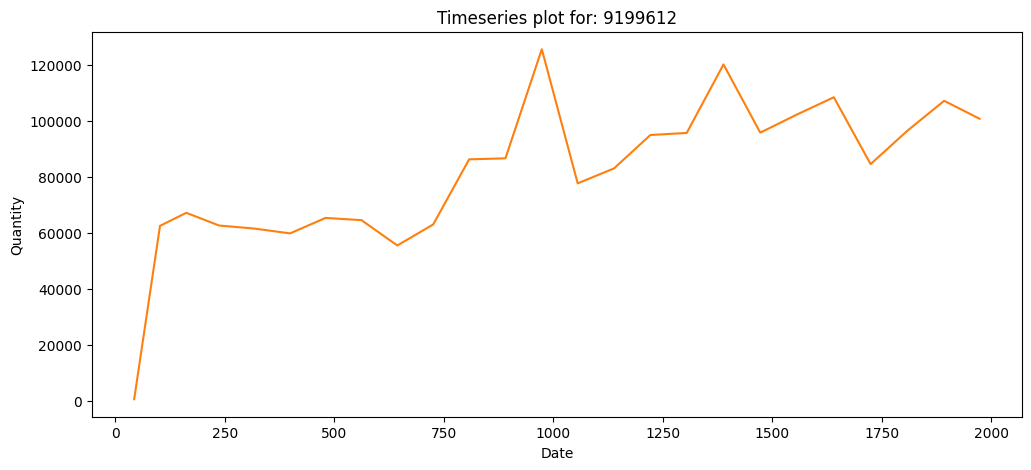

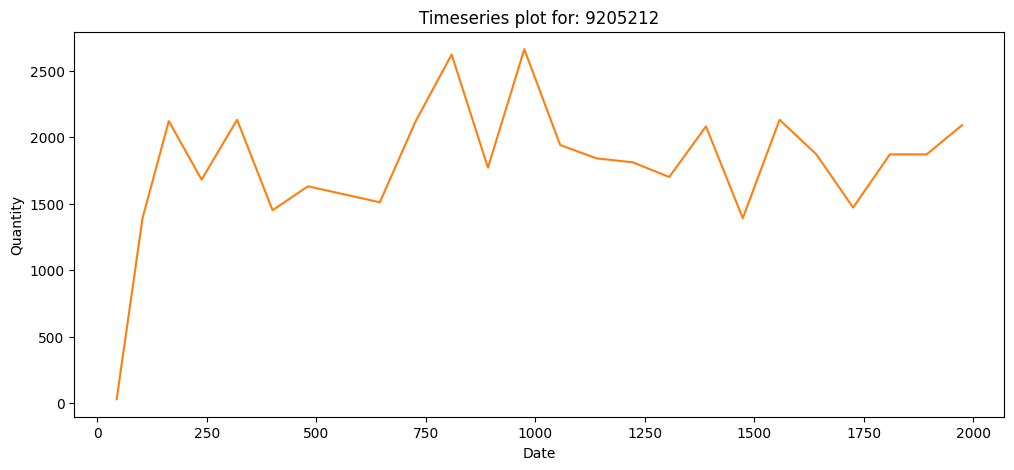

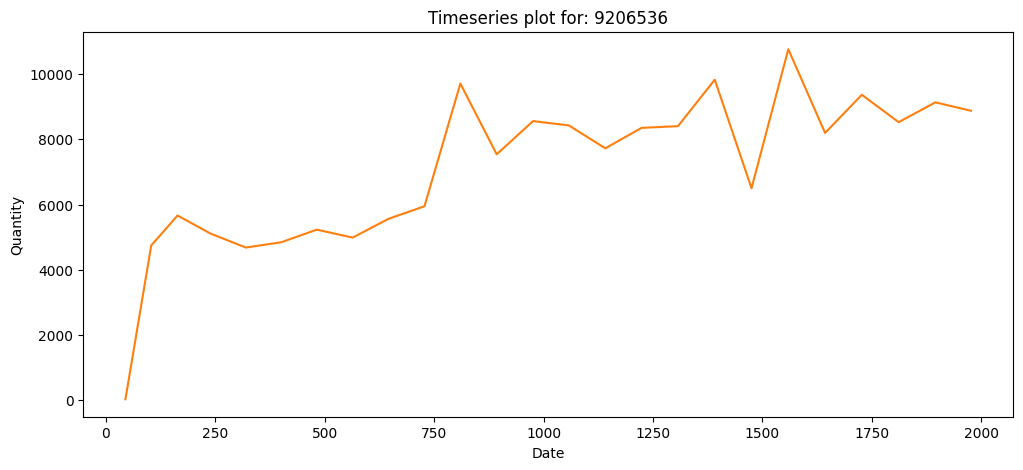

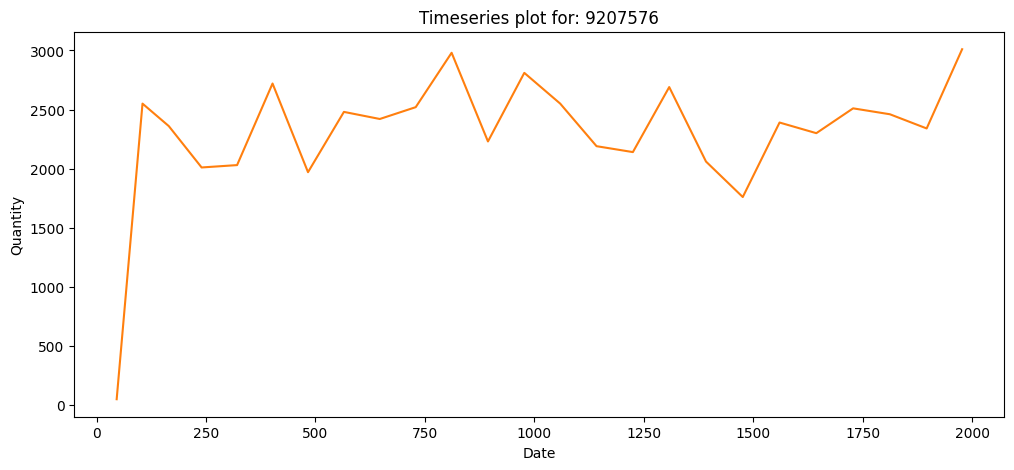

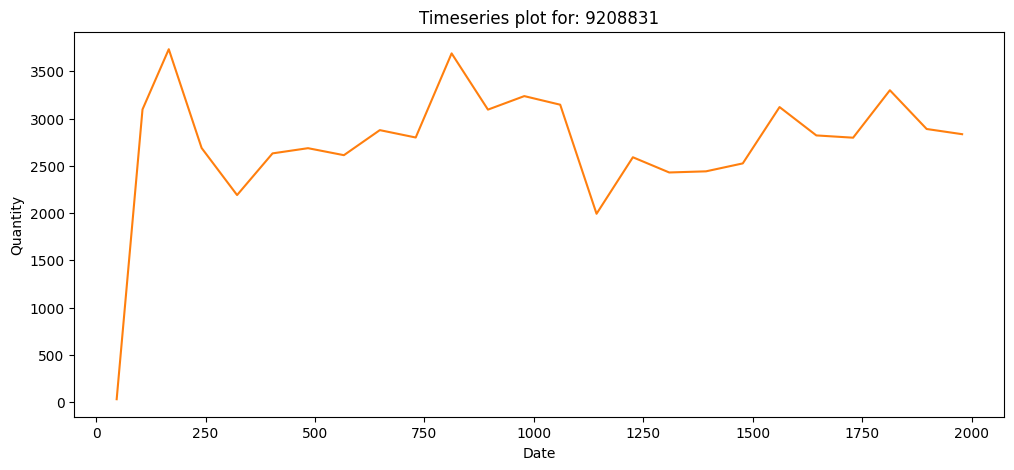

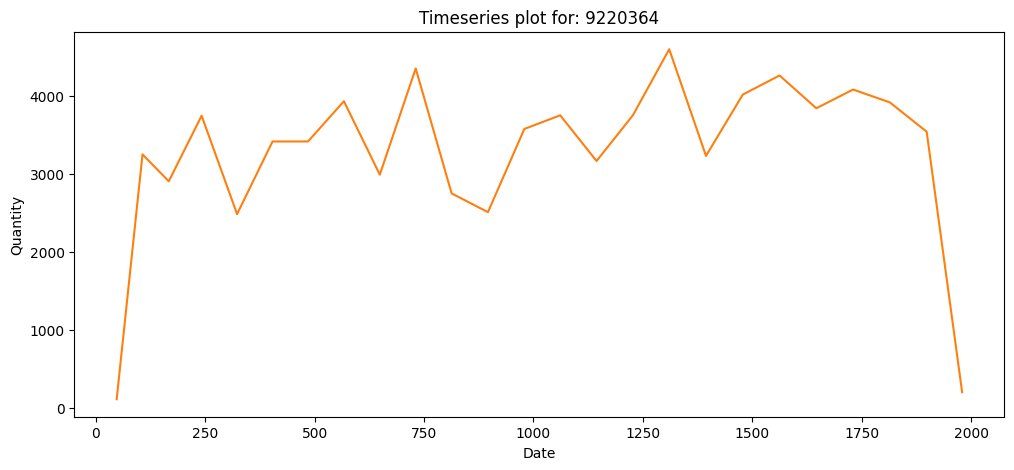

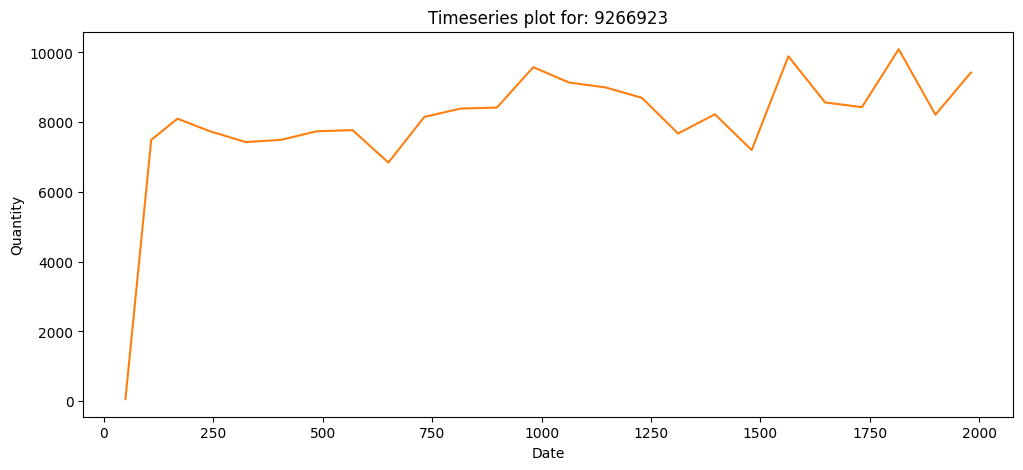

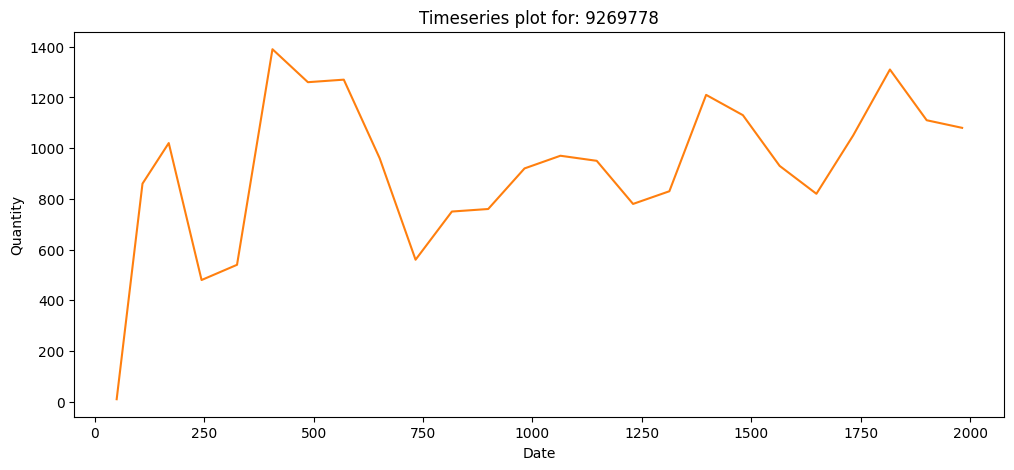

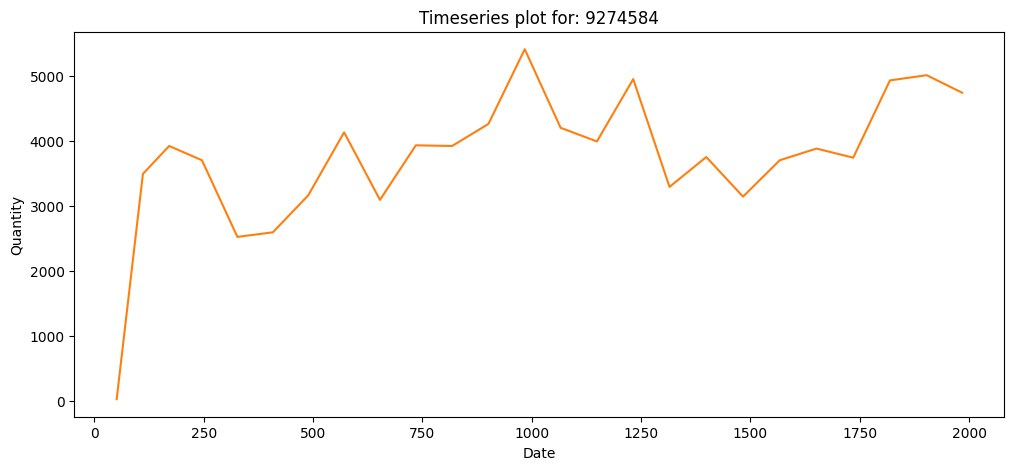

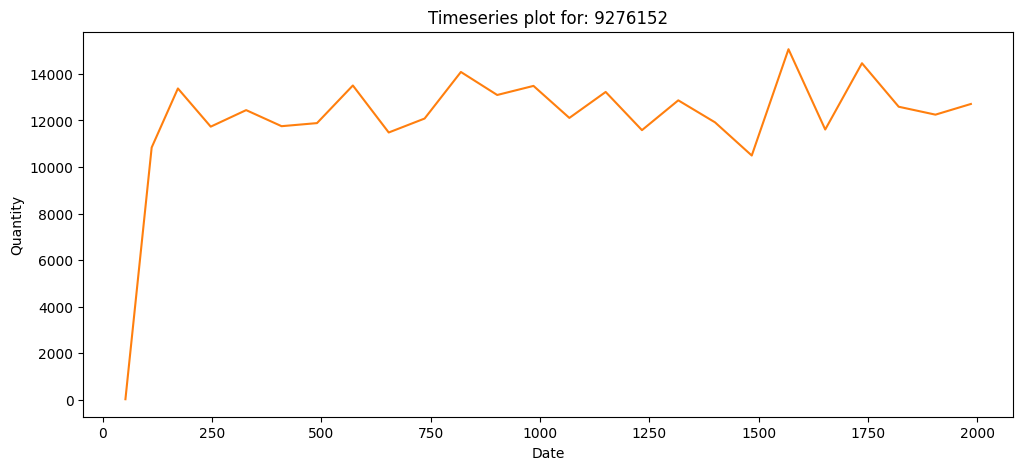

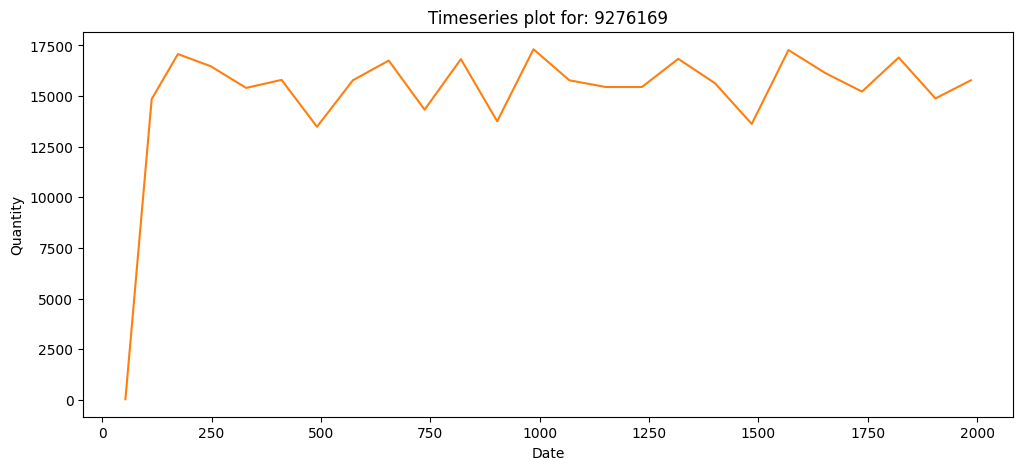

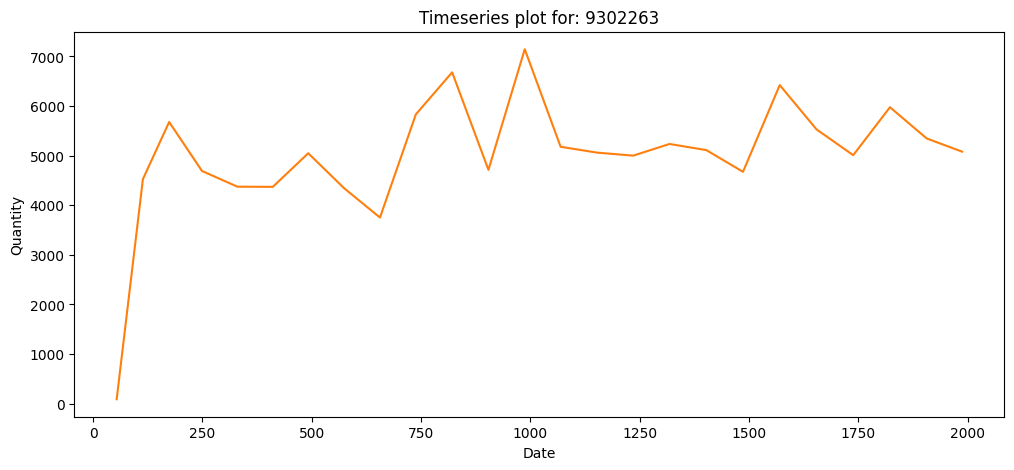

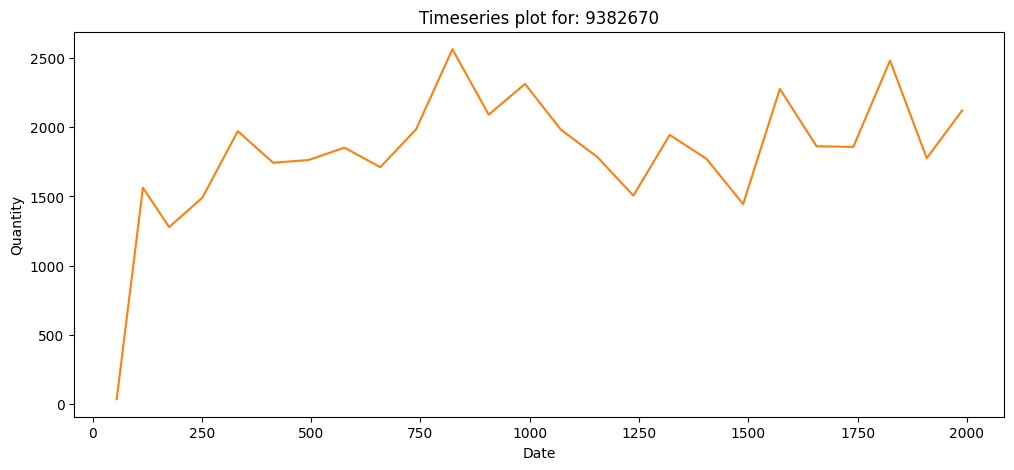

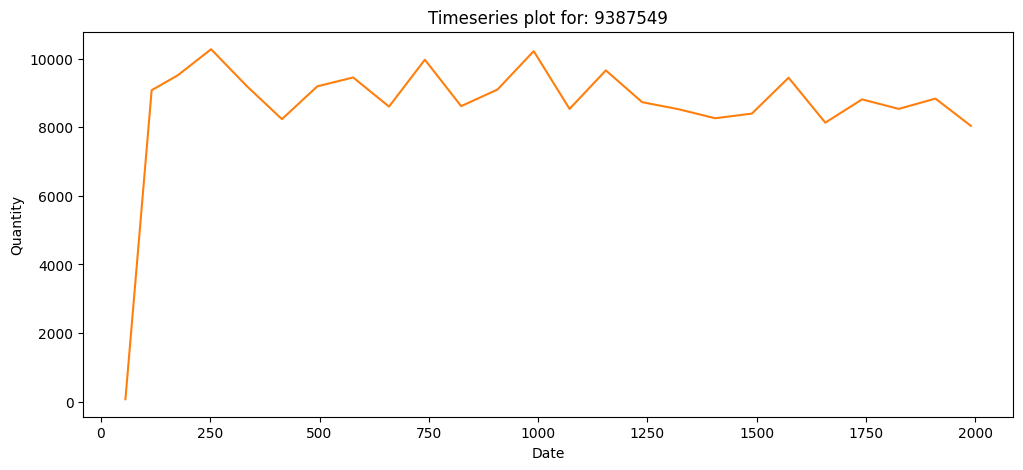

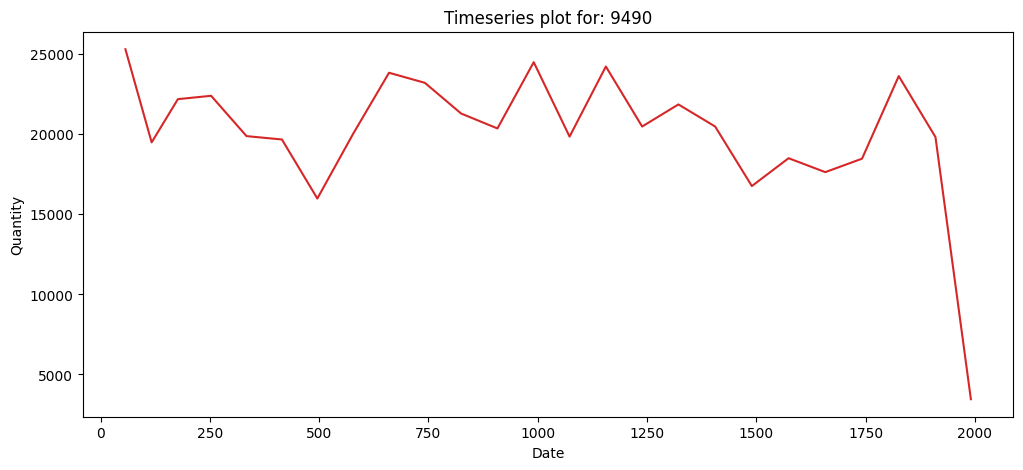

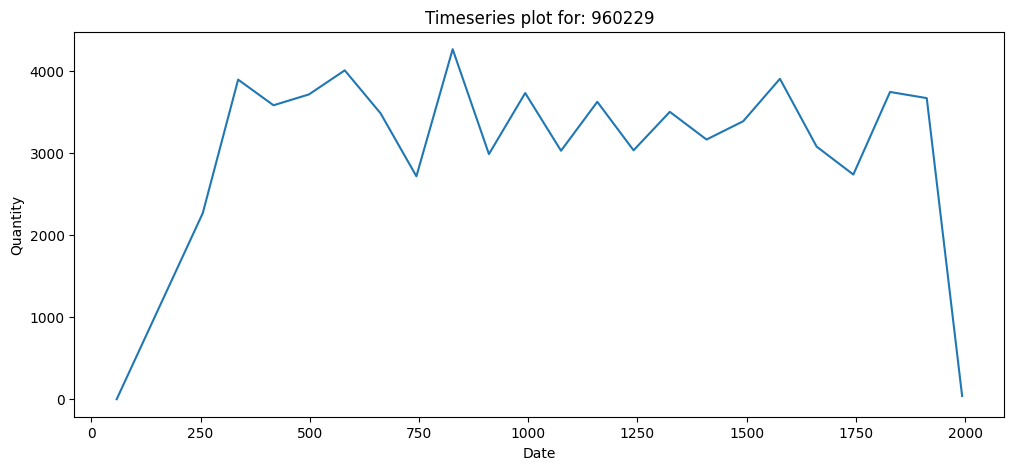

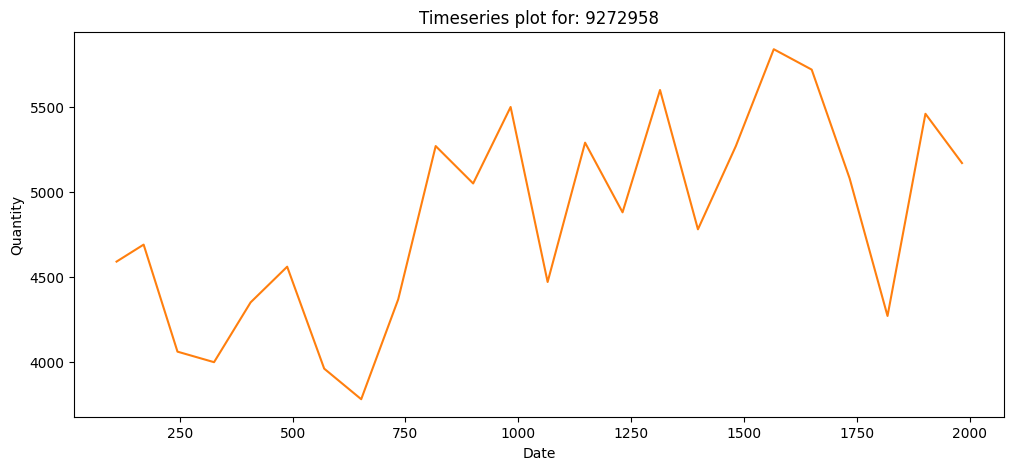

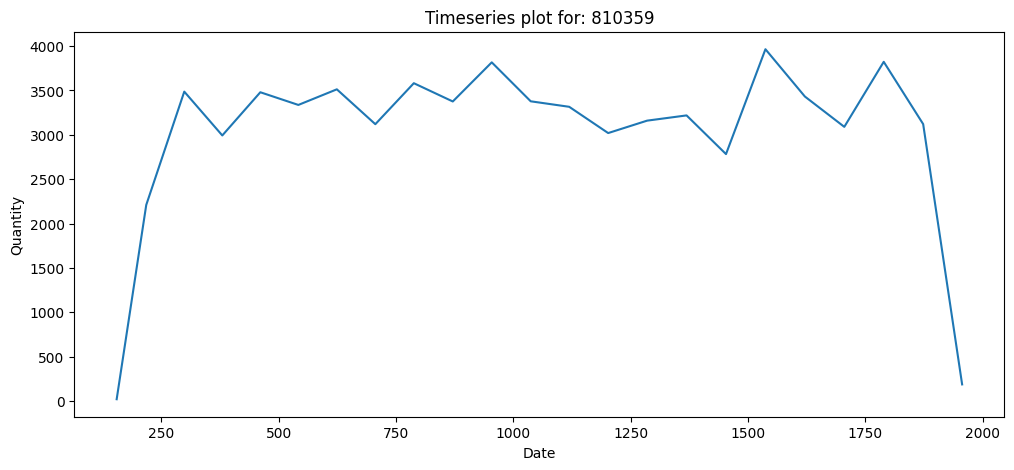

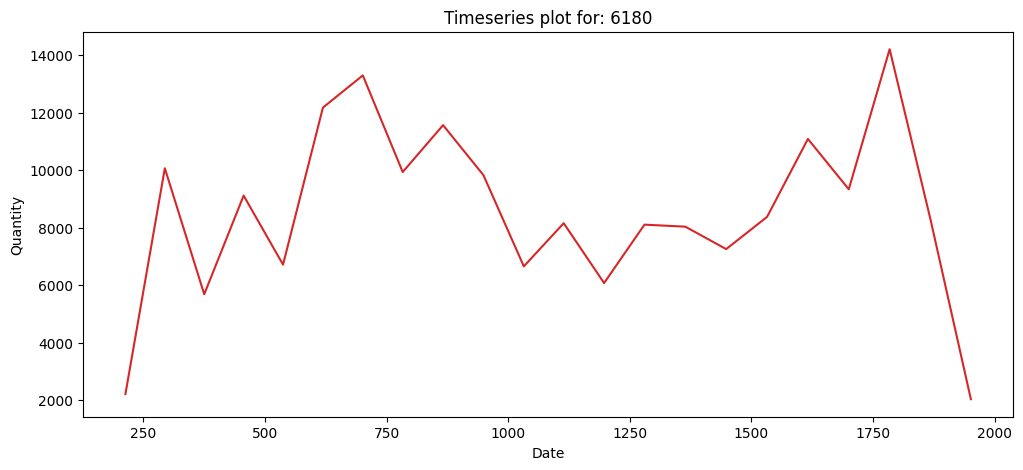

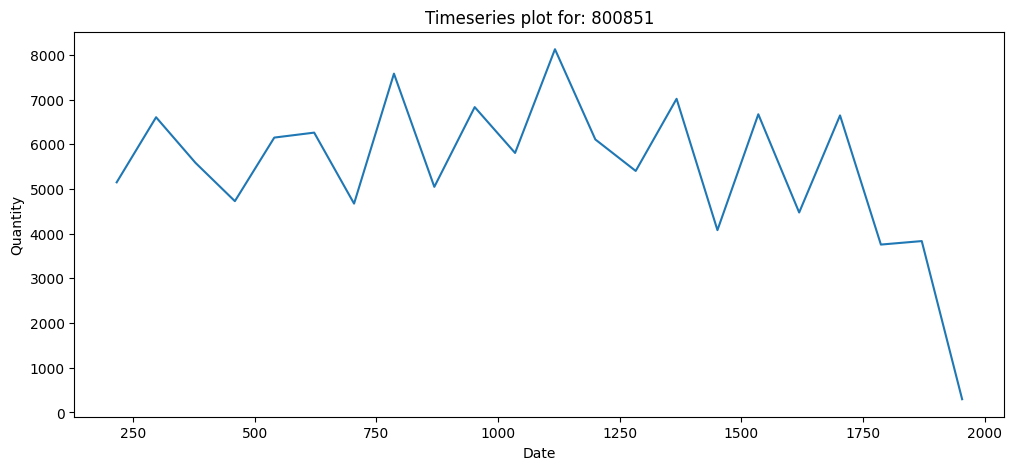

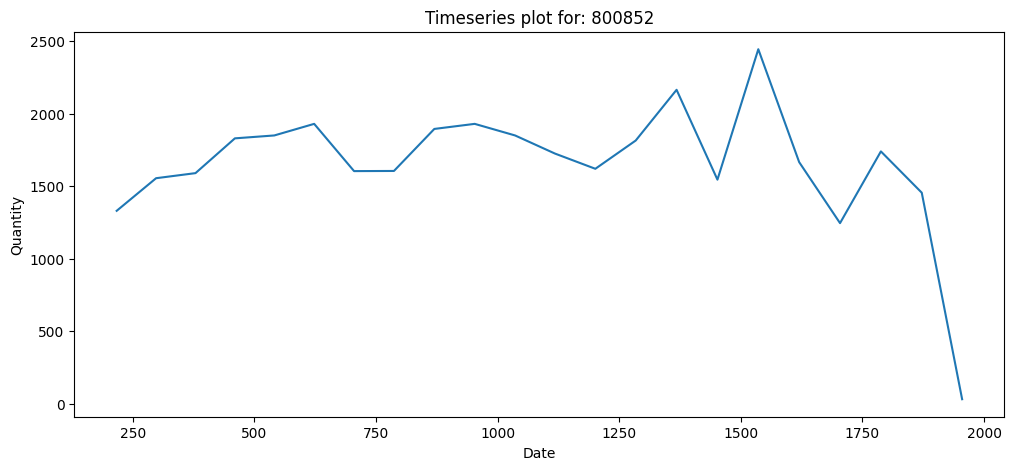

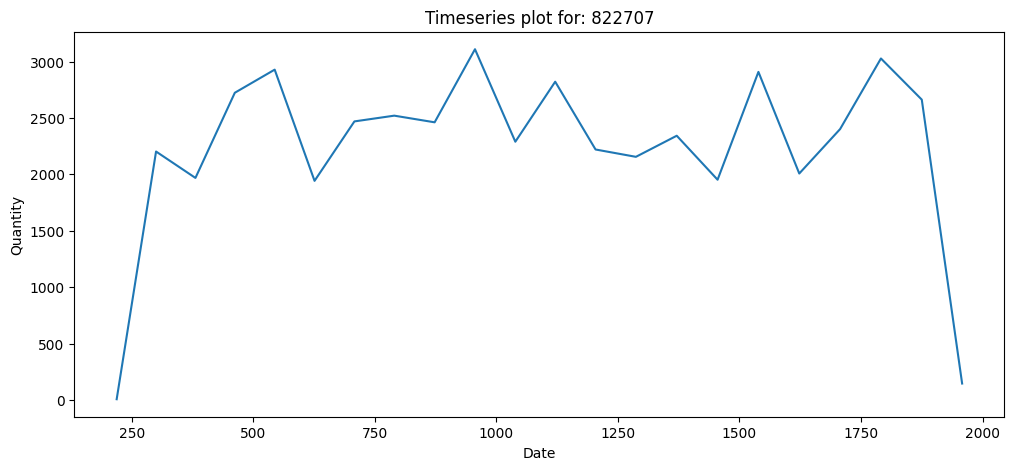

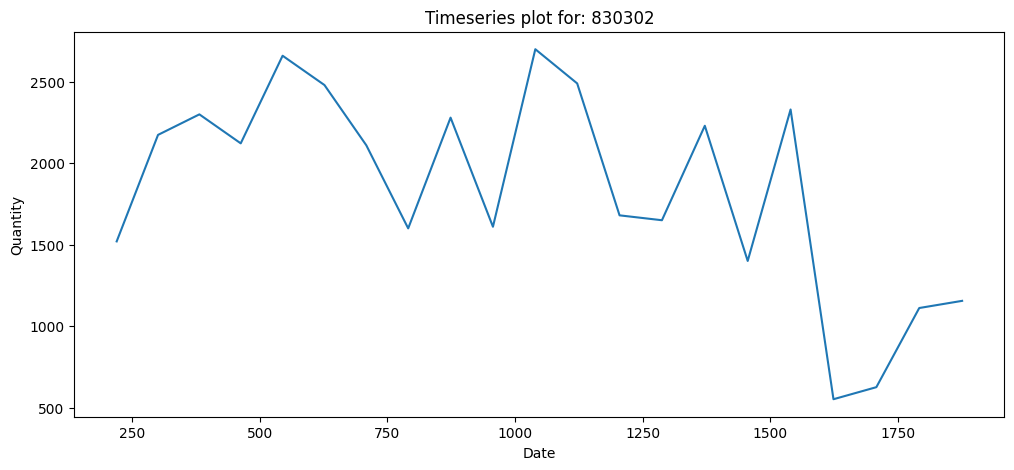

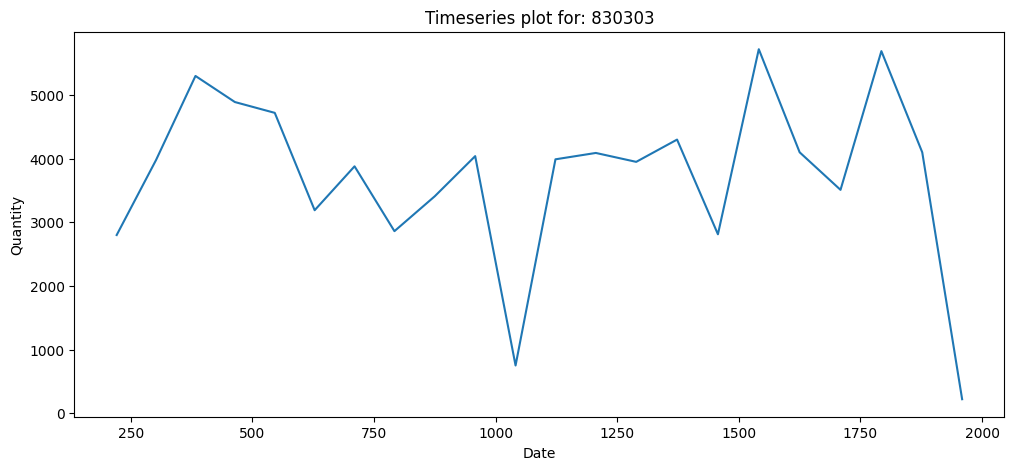

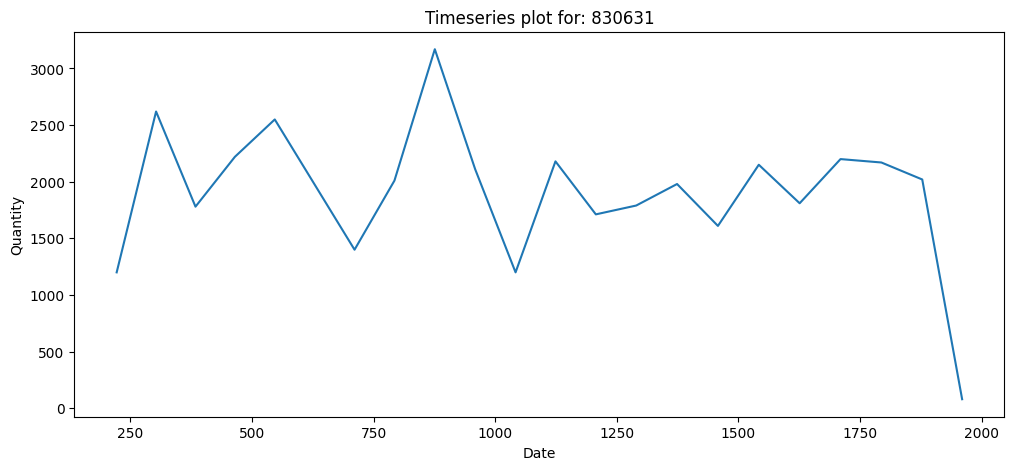

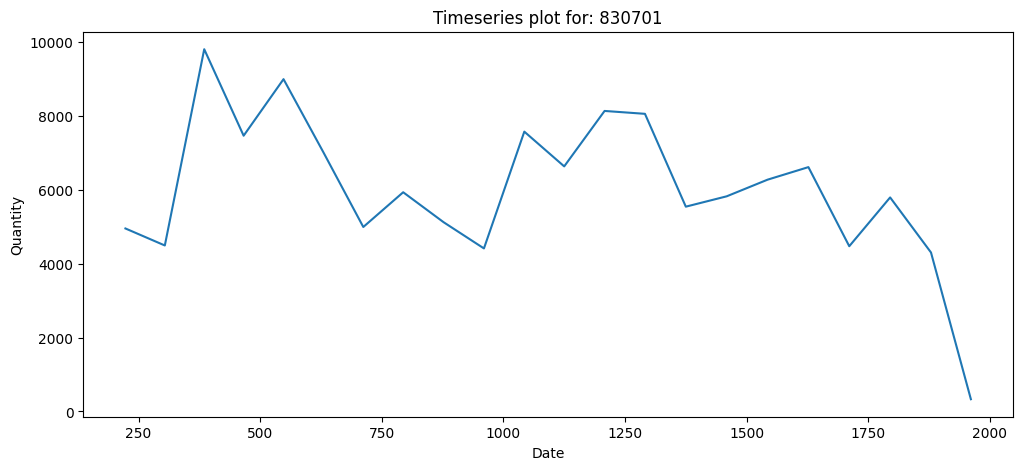

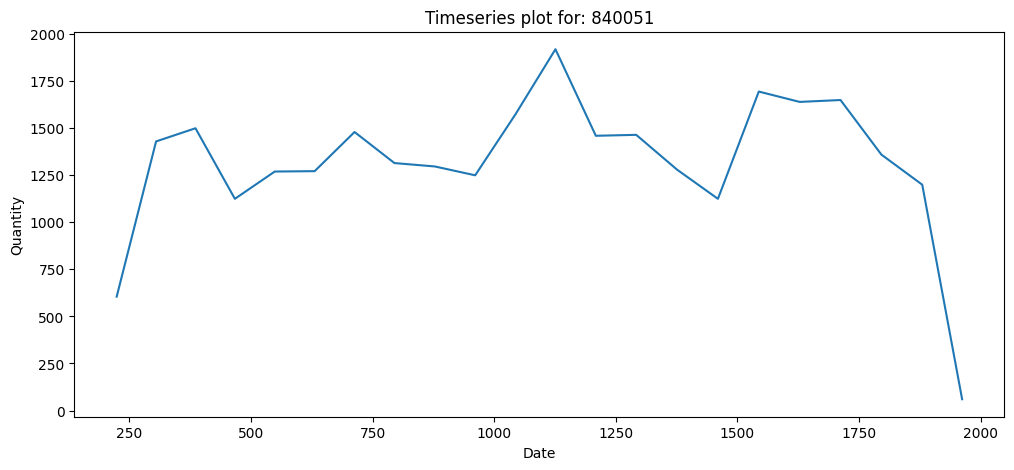

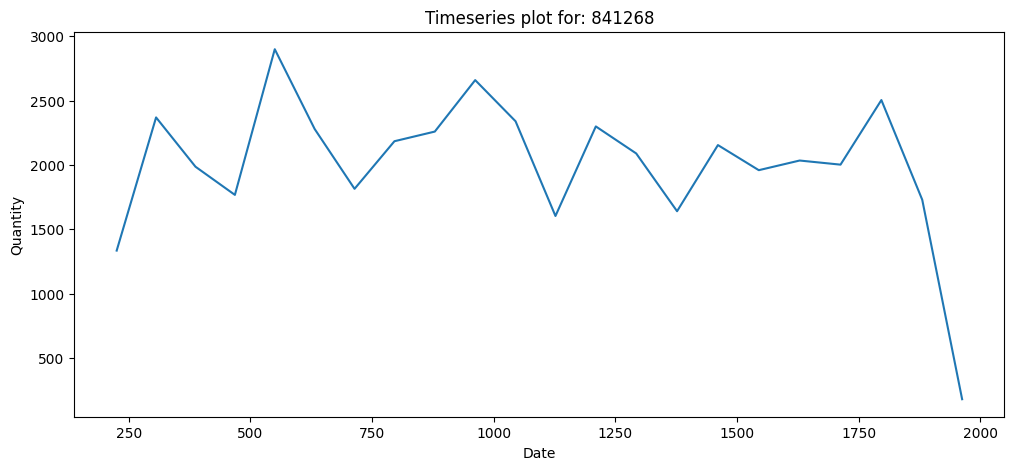

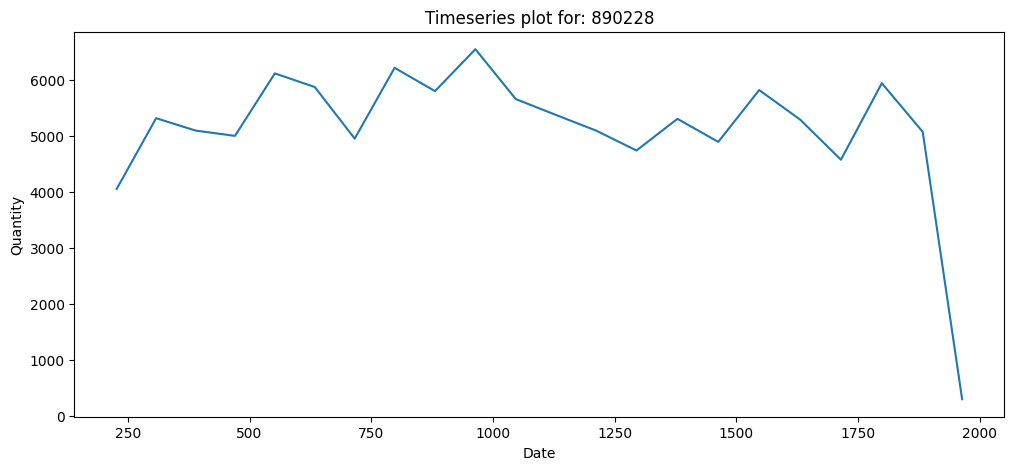

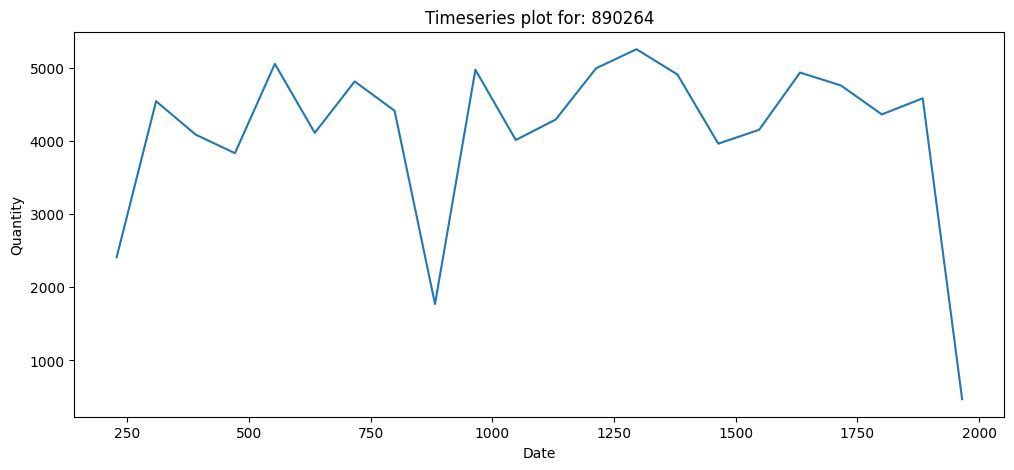

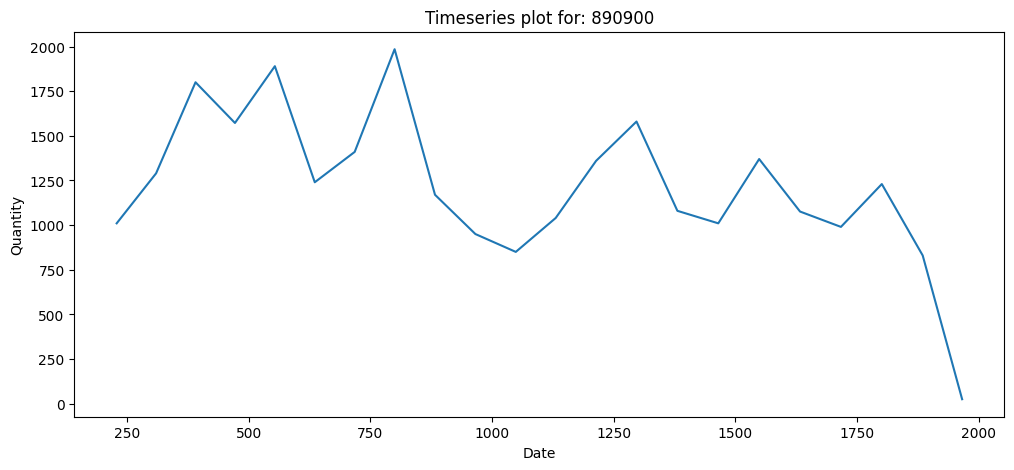

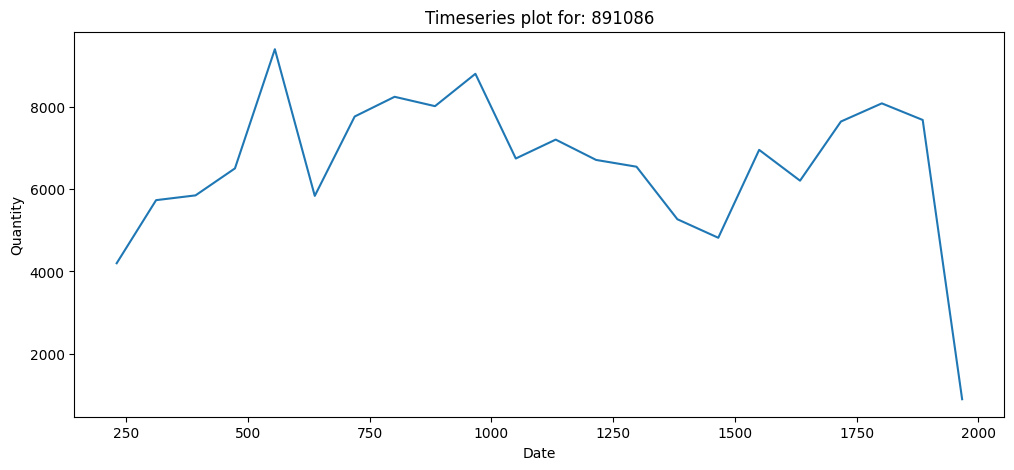

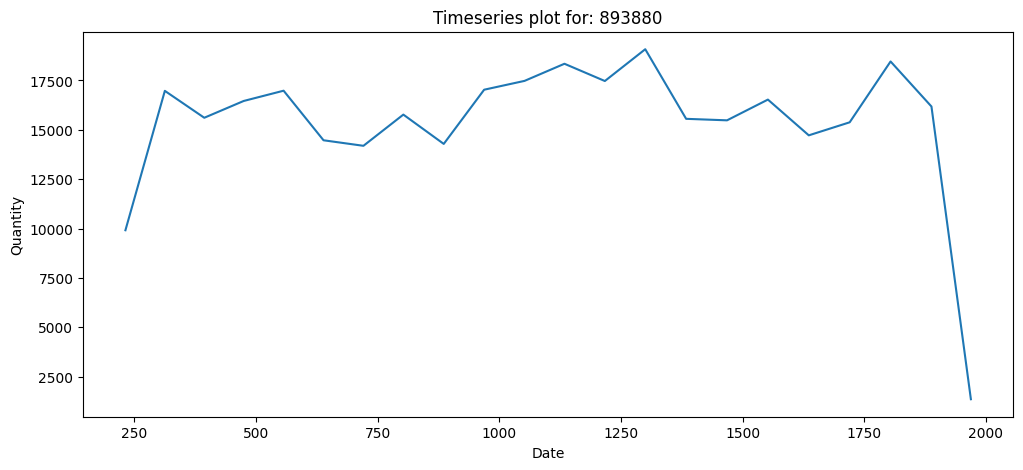

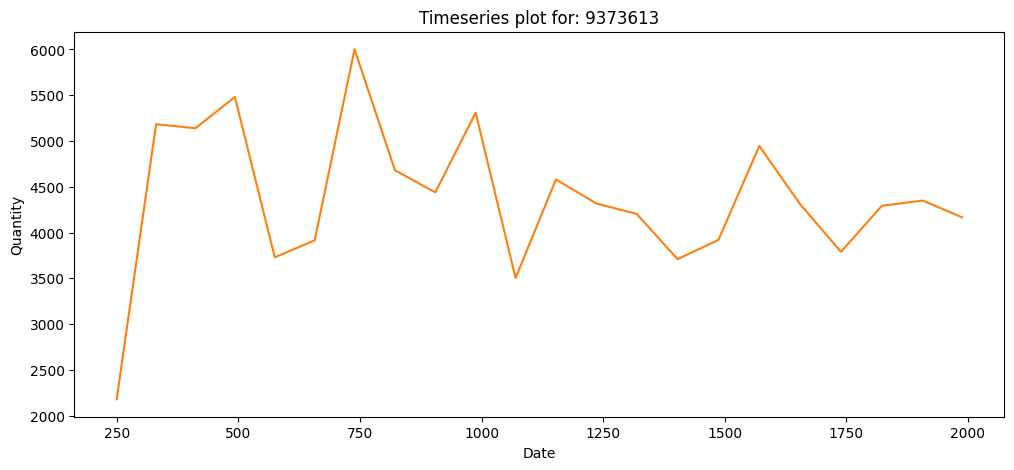

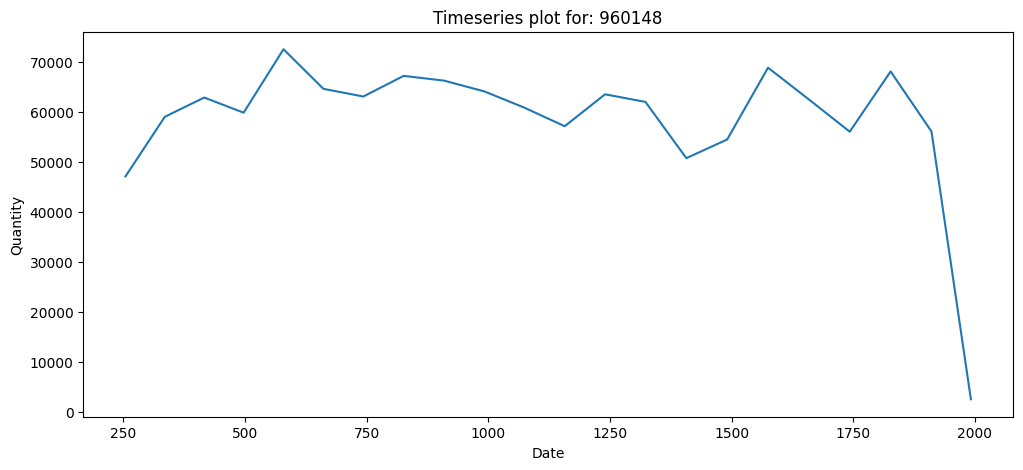

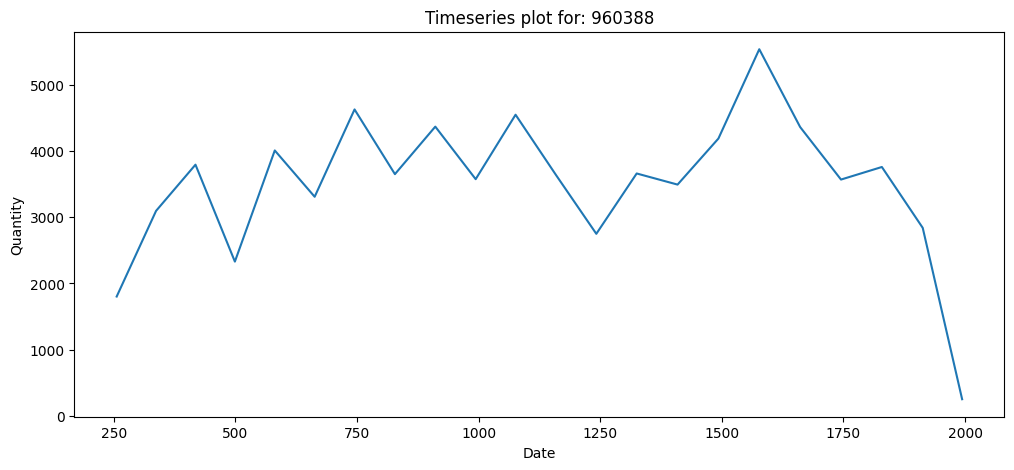

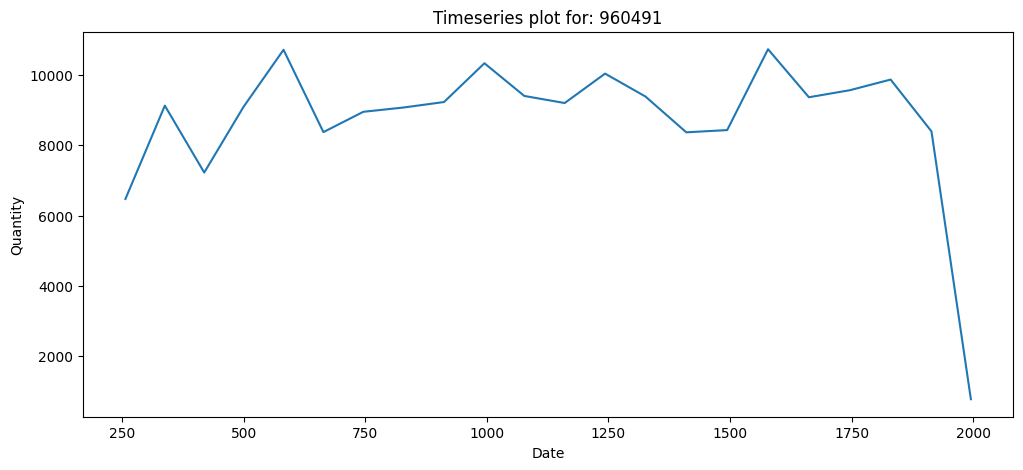

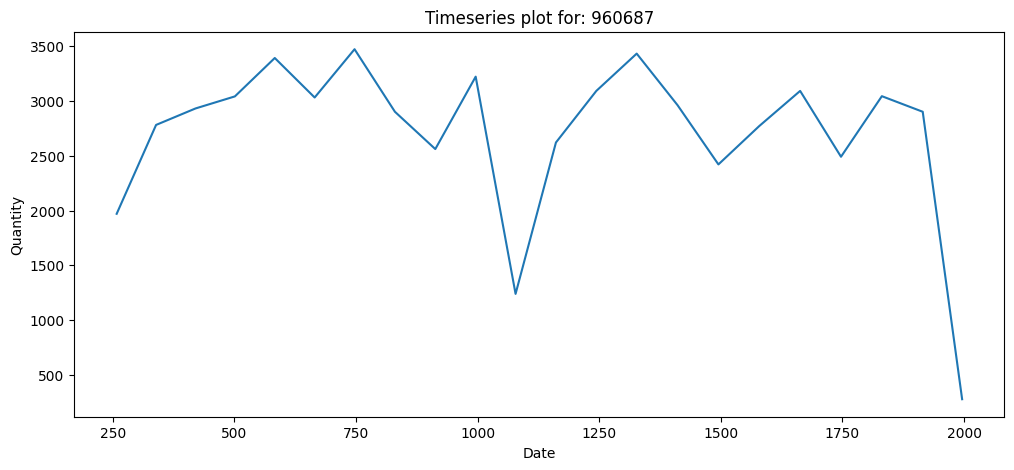

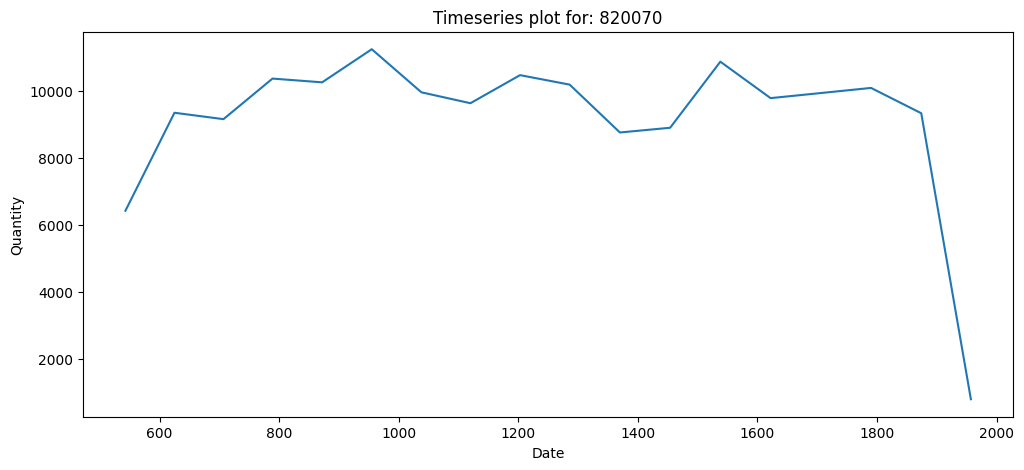

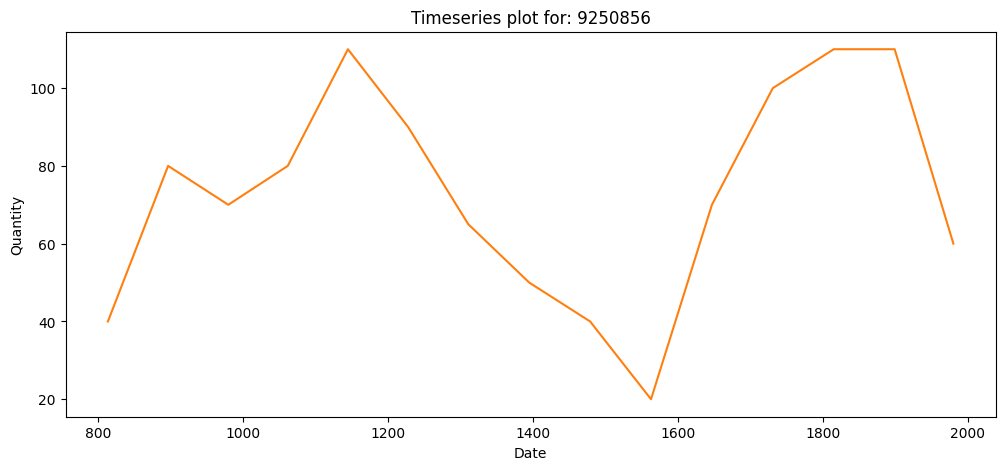

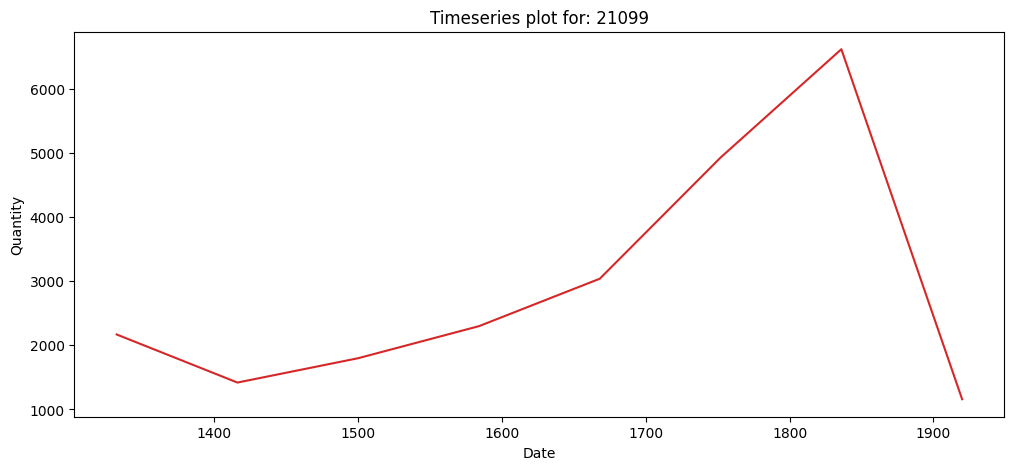

In [129]:
# Plotting the different timeseries
df_timeseries_plot['DATE'] = df_timeseries_plot.index

for medicine in df_timeseries_plot['ID_REF'].unique():
  x1, y1 = df_timeseries_plot[(df_timeseries_plot["ID_REF"] == medicine) & (df_timeseries_plot["ID_SITE_RATTACHE"] == "HOSPI_1")][["DATE", "QUANTITY"]].values.T
  x2, y2 = df_timeseries_plot[(df_timeseries_plot["ID_REF"] == medicine) & (df_timeseries_plot["ID_SITE_RATTACHE"] == "HOSPI_2")][["DATE", "QUANTITY"]].values.T
  x3, y3 = df_timeseries_plot[(df_timeseries_plot["ID_REF"] == medicine) & (df_timeseries_plot["ID_SITE_RATTACHE"] == "HOSPI_3")][["DATE", "QUANTITY"]].values.T
  x4, y4 = df_timeseries_plot[(df_timeseries_plot["ID_REF"] == medicine) & (df_timeseries_plot["ID_SITE_RATTACHE"] == "HOSPI_4")][["DATE", "QUANTITY"]].values.T

  plt.figure(figsize=(12, 5))
  plt.title('Timeseries plot for: ' + str(medicine))
  plt.xlabel('Date')
  plt.ylabel('Quantity')
  plt.plot(x1, y1)
  plt.plot(x2, y2)
  plt.plot(x3, y3)
  plt.plot(x4, y4)
  
  plt.show()